In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import scipy.stats as stats
import pymc as pm
from scipy.special import expit, logit
import pytensor.tensor as pt
from pymc.distributions.transforms import Ordered

from collections import Counter
import pickle
import random
import itertools
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

pandas==2.2.0
numpy==1.26.4
seaborn==0.13.2
arviz==0.17.0
pymc==5.10.3


In [3]:
## convenience functions for plotting and comparing true and estimated values

# a function to calculate the correlations between the true orders of sets and the posterior predictive orders
def get_corrs(ppc, true):
    N = 2000
    all_values = ppc.posterior_predictive['paper_values'].values.reshape(-1, B, K)
    
    # Generate random indices for selection
    selected_indices = np.random.randint(0, all_values.shape[0], size=(N, B, K))
    # sample from the posteriors
    result = np.take_along_axis(all_values, selected_indices, axis=0)
    # sort the posterior predictive samples
    sorted_result = np.argsort(result, axis=-1)

    # now get the correlations

    set_values = []
    overall = []
    for i in range(N):
        correlations_per_set = compute_spearmans_per_set(real_paper_ranks, sorted_result[i,:])
        overall_correlation = compute_overall_spearmans(real_paper_ranks, sorted_result[i,:])
        set_values.append(correlations_per_set)
        overall.append(overall_correlation)

    return set_values, overall

# a function to calculate the sum of distances between the true rank of a paper and the estimated rank
# so, lower is better
def calculate_distance(arr1, arr2):
    distances = []
    for row1, row2 in zip(arr1, arr2):
        # Find the index of each element in row2 in row1 and calculate the absolute difference in indices
        distance = sum(abs(np.where(row1 == elem)[0][0] - idx) for idx, elem in enumerate(row2))
        distances.append(distance)
    return distances


# a function to plot the comparison of the true and estimated values of the simulations
def plot_results(trace,ppc):

    # check how often the rankings were correct
    estimated_ranks = np.argsort(trace.posterior['paper_values'].mean(dim = ['chain','draw']).values)
    matching_scores = np.sum(estimated_ranks == real_paper_ranks, axis = 1)
    values_correct, counts_correct = np.unique(matching_scores, return_counts=True)

    # check how far the rankings were from correct

    values_distance, counts_distance = np.unique(calculate_distance(estimated_ranks, real_paper_ranks), return_counts=True)

    # calculate ppc correlations

    sets, overalls = get_corrs(ppc, real_paper_ranks)

    fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = (13,5))

    # plot the number of times a ranking was correct
    ax[0,0].bar(values_correct, counts_correct, color='skyblue')
    ax[0,0].set_title('Frequency of Matching Scores')
    ax[0,0].set_ylabel('Frequency')

    # plot the counts of the summed distance from correctness per set
    ax[0,1].bar(values_distance, counts_distance, color='skyblue')
    ax[0,1].set_title('Frequency of Distance Scores')
    ax[0,1].set_ylabel('Frequency')

    ax[1,0].hist(overalls, bins = 50)
    ax[1,1].hist(np.ravel(np.array(sets)), bins = 50)
    
    ax[1,0].set_title('Overall correlations between true and estimated values')
    ax[1,1].set_title('Correlations per set between true and estimated values')

    fig.tight_layout()

# a function to determine how many rows and columns to plot
def calculate_subplot_grid(total_subplots):

    # Minimum number of columns is 4, unless total subplots are less than 4
    min_columns = min(3, total_subplots)

    # Calculate the number of required rows
    rows = (total_subplots + min_columns - 1) // min_columns

    # Adjust columns based on total subplots and rows
    columns = (total_subplots + rows - 1) // rows

    return (rows, columns)

# a function to plot the prior predictive checks
# for parameters with more than 1, we just plot a single one (because all the same)
def plot_priors(pr, variables):
    
    factors = calculate_subplot_grid(len(variables))
    ncols = factors[1]
    nrows = factors[0]
    fig, axs = plt.subplots(ncols = ncols,nrows = nrows, figsize = (ncols*7,nrows*3))

    for ax, para in zip(axs.flat, variables):
        if len(pr.prior[para].shape) == 3:
            az.plot_posterior(pr.prior[para][:,:,0], ax=ax)
        elif len(pr.prior[para].shape) == 2:
            az.plot_posterior(pr.prior[para],ax=ax)
        else:
            az.plot_posterior(pr.prior[para][:,:,0,0],ax=ax)
    plt.suptitle('priors', fontsize = 20, y = 1.1) 
    
    fig.tight_layout()


# function to plot the posterior distributions and the true values used for the simulation
# both are z score standardized
def plot_posteriors(trace, variables):
    
    factors = calculate_subplot_grid(len(variables))
    ncols = factors[1]
    nrows = factors[0]
    fig, axs = plt.subplots(ncols = ncols,nrows = nrows, figsize = (ncols*7,nrows*4))

    fontsize = 22
    
    for ax, para in zip(axs.flat, variables):
        estimates = standardize_trace(trace,para)
        az.plot_forest(estimates, combined = True, textsize = fontsize, ax=ax)
        y_locs = ax.yaxis.get_majorticklocs()[::-1]
        true =z_score_standardize(true_values[para])
        ax.scatter(np.ravel(true), y_locs, c='r', zorder=5)
        
    plt.suptitle('Posteriors', fontsize = 25, y = 1.03) 
    
    fig.tight_layout()


#function to z score standardize the posterior distribution for one parameter
def standardize_trace(trace, var_name):

    mean = trace.posterior[var_name].values.mean()
    std = np.std(trace.posterior[var_name].values)
    return (trace.posterior[var_name] - mean) / std

#function to z score standardize a numpy array
def z_score_standardize(arr):

    mean = np.array([arr]).mean()
    std = np.array([arr]).std()
    standardized_arr = (arr - mean) / std
    return standardized_arr


# function to plot the estimated paper values along with the true value
# both are z score standardized
# they are plotted by set of 5
def plot_paper_values(trace, true_values, parameter_name='paper_values'):
    # Assuming true_values is a dictionary or structure that contains 'paper_values'
    true_paper_values = true_values[parameter_name]


    num_rows = int(B / 3)  # Two columns, so half as many rows, rounded up
    
    # Standardize the trace for plotting
    standardized_trace = standardize_trace(trace, parameter_name)  # Assuming this function is defined elsewhere
    
    # z-score standardize the true values for comparison
    standardized_true_values = z_score_standardize(np.ravel(true_paper_values)) # Assuming this function is defined elsewhere

    fig, axs = plt.subplots(num_rows, 3, figsize=(12, num_rows*1.5), sharex = True, sharey = True)  # Adjust height as needed

    for ax, i in zip(axs.flat, range(B)):
    #     # Plot forest plot for the subset
        az.plot_forest(trace.posterior[parameter_name][:,:,i,:], combined=True, ax=ax)
        
    #     # Calculate positions for the true values scatter plot
        y_locs = ax.yaxis.get_majorticklocs()[::-1]
        true = standardized_true_values[i*5:(i*5)+5]
    #     # Scatter plot for true values
        ax.scatter(true, y_locs, c='r', zorder=5)    
        
    plt.suptitle('True and estimated latent true value of each paper', y = 1.01)

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Function to compute Spearman's correlation for each set
def compute_spearmans_per_set(true_values, estimated_values):
    assert true_values.shape == estimated_values.shape, "Arrays must have the same shape"
    B, K = true_values.shape
    correlations = np.zeros(B)
    for i in range(B):
        correlation, _ = stats.spearmanr(true_values[i], estimated_values[i])
        correlations[i] = correlation
    return correlations

# Function to compute overall Spearman's correlation
def compute_overall_spearmans(true_values, estimated_values):
    flat_true = true_values.flatten()
    flat_estimated = estimated_values.flatten()
    overall_correlation, _ = stats.spearmanr(flat_true, flat_estimated)
    return overall_correlation

# a function to check whether the proportion of 1s per rater in the posterior predictive checks matches the observed porportions
def plot_binary_ppc(ppc):

    sampled_per_rater = az.extract(ppc.posterior_predictive['binary'].mean(dim = ['binary_dim_2','binary_dim_4']))
    rater_props = binary_data.mean(axis = 0).mean(axis = 1)
    
    grid = calculate_subplot_grid(J)
    
    fig, axs = plt.subplots(ncols = grid[0], nrows = grid[1], figsize = (17, grid[1]*2))
    
    for ax, i in zip(axs.flat, range(J)):
        ax.hist(sampled_per_rater['binary'][i,:].values)
        ax.axvline(rater_props[i], color = 'r')
    plt.suptitle('Posterior predictive proportion of 1s and true proportion of 1s for each rater')


# Introduction

These are simulations to develop an analysis model for a study on the use of peer review for assessing the societal relevance of humanities research. The OSF page of the project can be found [here](https://osf.io/tnsfz/). In this notebook, we simulate data that mimics the data we collected, and gruadually add complexity to the model while tracking whether the model's estimate align with the true values.

## Data collection and study design

We hired PhD students and holders to read sets of five abstracts, order these abstracts by how societally relevant (defined in reference to [Kitcher's ideal committee](https://www.amazon.com/Science-Democracy-Oxford-Studies-Philosophy/dp/0195145836), see also [here](https://www.redalyc.org/pdf/3397/339730822003.pdf)) they are, and assess for each individual abstract whether they think it would be accepted for funding by an ideal committee. Each of the sets of five abstracts had one paper of each of the five target fields. Raters were hired both within and outside of humanities research. If they were humanities researchers, we also recorded their field of specialization. The abstracts were sampled randomly from bookabstracts and paper abstracts on WoS (see OFS page for more details on this). Two members of the research team rated all the papers for 8 content/causes codes (1 or 0), and then settled on consensus ratings through deliberation. 

We ran two pilot studies, first with only philosophy papers and binary ratings, and then with two groups of around 8 raters from KU Leuven who rated 69 sets of abstracts from 5 humanities fields. These data were used to develop the statistical methods, choose content codes, and refine the survey for the main study. The main study hired two groups of 10 raters (10 humanities and 10 non-humanities) from across the world (split between genders and WEIRDness) who rated 33 sets of 5 abstracts.

## Data 

The data to be analysed here consists of:

- Rank data: each rater ranked all their sets of five abstracts from most societally relevant to least societally relevant. That means for each rater we have an array with 0, 1, 2, 3 ,4 in some order for each set.
- Binary data: each rater gave a either a '1' or a '0' to each of the abstracts. Importantly, we checked and enforced consistency between rank data and binary data, meaning that an abstract with a '1' could not be ranked below one with a '0' and vice versa.
- Participant data: for each rater, we recorded whether they are humanities scholars, what their humanities field was, and, for the main study, their country of residence and gender. Gender and WEIRDness do not figure in the registered hypotheses, and so will only be used in exploratory analysis. Hence, they are not simulated.
- Abstract data: for each abstract, we recorded the WoS field it was sampled from

## Model background

We model these data using thurstonian models. These are models that map discrete ranking data to a set of latent
continuous variables. These models estimate an aggregate ranking from a set of rankings from different raters, and can easily be extended to include covariates for both ranked items and the raters ranking them. More precisely, the models assume that individuals’ rankings are distributed around some aggregate ranking. This aggregate ranking is represented on a continuous latent scale. We will use a Bayesian implementation of such a thurstonian model. This allows us give the model a hierarchical structure (with different ranked sets to be estimated) and fit it using MCMC methods. For more on these models, see [here](https://osf.io/preprints/psyarxiv/t7szv), [here](https://www.cambridge.org/core/books/abs/cognitive-science-of-belief/modeling-individual-differences-in-beliefs-and-opinions-using-thurstonian-models/EA77D7FE721BAE4111E57E9A619D71EC) and [here](https://arxiv.org/pdf/1607.06051.pdf)

## Model evaluation

Below we simulate data in the way we think our data will be generated in reality, and then gradually build up the model to mimic this data generation process. As we add model complexity, hopefully we will capture the data better. We will evaluate this by comparing the estimated values with the true values. Note that we will mostly look at whether we manage to estimate the true ranks correctly. The latent scale that model is uses is not fixed by anything and so might not correspond to the scale on which the data is generated. We therefore always z score standardize before comparisons of latent estimated values with latent true values.

# Simulate data

In [4]:
### simulate new data

np.random.seed(2028)

## experiment setup
K = 5 # number of items being ranked
J = 10 # number of raters
B = 69 # number of sets of five abstracts

## true values

field_params = np.array([0.8,1,0,-0.2,-1.1])
field_values = np.tile(field_params, (B,1)) # for simulating


paper_intercepts = np.random.normal(0,0.5,(B,K))

content_params = np.array([0.4,0.9,-0.3,0.8,0,1,1.3]) 
content_presence = np.random.choice([0, 1], size=(B, K, len(content_params)), p=[0.8, 0.2]) 
content_values = np.sum(content_presence * content_params, axis=2) # for simulating


true_paper_values = paper_intercepts + content_values + field_values # sum field and content values to get the paper value

field_codes = np.random.randint(0,K,J) # raters are from one of the included fields
chauvinism_m = 1.5
chauvinism_s = 0.4
rater_chauv = np.random.normal(chauvinism_m, chauvinism_s, (1,J,1))

# chauvinism affects the ratings, so create an array of zeros apart form the papers where the rater field matches the paper field
chauv_array = np.zeros((B, J, K), dtype=int)
for i in range(J):
    chauv_array[:, i, field_codes[i]] = 1
chauv_true = chauv_array * rater_chauv # for simulating

strictness_m = 0
strictness_s = 0.3
strictness_params = np.random.normal(strictness_m, strictness_s, (1,J,1))


# difference in accuracy between raters (the latent estimate has the linear model as mean and this as the sd)
raters_sigma = np.random.uniform(0.05,0.3,(1,J,1))

## generate the data

# create the ranking data
real_paper_ranks = np.argsort(true_paper_values, axis = 1) # the true rankings per set, in case we need them
ratings_true = np.tile(true_paper_values[:, np.newaxis, :], (1, J, 1)) # array with for each rater for each paper the true paper values

# add noise and chauvinism to the true values. This is what determines the raters' ranking.
ratings = np.random.normal(ratings_true + chauv_true, raters_sigma) # simulate the estimated scores on the latent scale
rank_data = np.argsort(ratings, axis=2) # the ranked sets as we get them from raters

# create the binary data
ratings_strictness = ratings + strictness_params # estimated paper value (used for rank data) combined with strictness
transformed_ratings_strictness = expit(ratings_strictness) # inverse logit function to transform the values to a probability



true_values = {"fields":field_params,
              "content":content_params,
              "chauv_mean":chauvinism_m,
               "chauv_sd": chauvinism_s,
              "chauvinism":rater_chauv,
              "sigma":raters_sigma.mean(),
              "strictness_mean":strictness_m,
               "strictness_sd":strictness_s,
              "strictness":strictness_params,
              "paper_ranks":real_paper_ranks,
              "paper_values":true_paper_values,
              "paper_intercepts":paper_intercepts}

## for indexing in the model
## The indexing is a bit tricky because of all the 3D arrays. At some point we could use coords in pm.

# fields idx
fields_presence = np.tile(np.arange(K), (B, 1))

# content parameters idx
content_presence = content_presence.reshape(B*K,len(content_params))

# original order of the observed rank data, needed to get them back into that order for the binary scoring
rank_data_argsort = np.argsort(rank_data, axis=2) 

# the observed rank data as it goes into the model
rank_data = np.argsort(ratings, axis=2)

# Observed binary data
binary_data = np.random.binomial(1, p = transformed_ratings_strictness)

# chauvinism idx
chauv_array = np.zeros((B, J, K), dtype=int)
for i in range(J):
    chauv_array[:, i, field_codes[i]] = 1


# Model1: Simple thurstonian model

Let's start with a model that only incorporates the two rating tasks, and nothing else. We use a normal prior for the paper values and latent values, and then estimate the ranking for each set separately. The model mimics the rating process: the latent values (i.e. rater estimates of the value of that paper) get a normal prior with the real paper value as the mean. In this first model, the real paper value just is a normal prior for each paper. In subsequent models, this will be a linear model with parameters for field, context and chauvinism.

Usually these thurstonian models are not identified, and you have to manually fix one value to fix the scale. Here that doesn't work, because we are estimating the ranking of many sets at the same time, and we cannot set a value for each set (we don't know that these latent values are the same across sets). This doesn't matter in this model, as it should be identified through the binary data, which is connected to the latent values.

In [5]:
with pm.Model() as model1:

    paper_values = pm.Normal('paper_values', 0, 1, shape=(B,K))
    mu = pm.Deterministic('mu', pt.tile(paper_values[:,pt.newaxis,:],(1,J,1)))
    reordered_mu = pm.Deterministic('reordered_mu', pt.take_along_axis(mu, rank_data, axis = -1))

    latent = pm.Normal('latent',
                       mu=reordered_mu,
                       sigma=1, # using sd does not work yet
                       transform=Ordered(), 
                       shape=(B,J,K),
                       # have to set test value to avoid issues with negative numbers
                       testval=np.tile(np.tile(np.arange(K), (B, 1))[:, np.newaxis, :], (1, J, 1))) 

    latent_reshaped = pt.take_along_axis(latent, rank_data_argsort, axis = -1)

    binary = pm.Bernoulli('binary',logit_p = latent_reshaped, observed = binary_data)
    pr1 = pm.sample_prior_predictive()

Sampling: [binary, latent, paper_values]


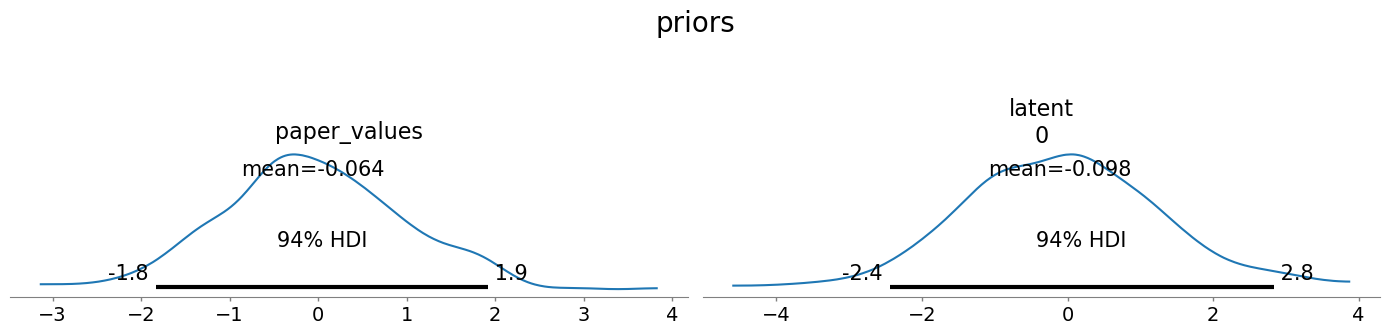

In [6]:
plot_priors(pr1, ['paper_values','latent'])

In [7]:
with model1:
    trace1 = pm.sample(1000, tune = 1000, idata_kwargs={"log_likelihood": True},target_accept = 0.8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [paper_values, latent]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 317 seconds.


In [8]:
with model1:
    ppc1 = pm.sample_posterior_predictive(trace1, var_names = ['paper_values','binary'])

Sampling: [binary, latent, paper_values]


In [9]:
trace1.to_netcdf("...\SimulTrace1.nc")

'C:\\Users\\conix\\Documents\\IIH_localtraces\\SimulTrace1.nc'

In [10]:
trace1 = az.from_netcdf("...\SimulTrace1.nc")

**Notes on the visualizations:**

The **distance scores** in the plots here and below show the frequency of the distances of the estimated indices from the correct indices summed by set. For example, if for set 1 the model estimates [0,1,2,3,4] and the real order is [1,0,3,4,2], the distance score for that set is 1 + 1 + 1 + 1 + 2 = 6. So, for the distance score, lower is better. The **matching scores** simply show how often the model got the rank correct, so for that higher is better. Note that these counts simply use the mean of the posterior, and do not incorporate uncertainty. If the latent values are close to each other, the model might give a pretty high probability for other rankings as well.

The **overal correlations** show Spearman's rank correlation coefficient across all sets (comparing true ranks with estimated ranks). The **correlations per set** show Spearman's rank correlation coefficient for each set. Both of these are calculated using posterior predictive samples.

The **posterior predictive proportion of 1s** shows the distribution of 1s the model expects a rater to have when we run the trial many times. The line in red shows the true proportion. If the model works well, the red line should coincide with the posterior predictive samples.

The plot with the **true and estimated paper values** shows the posterior distributions of the parameters in the models that represent the true paper values. The red dots show the values used for simulation. Note that both have been z score standardized, because the model and the simulations aren't necessarily on the same scale. What matters most in this figure are the orders of the rankings, as this is what we are trying to get correct.

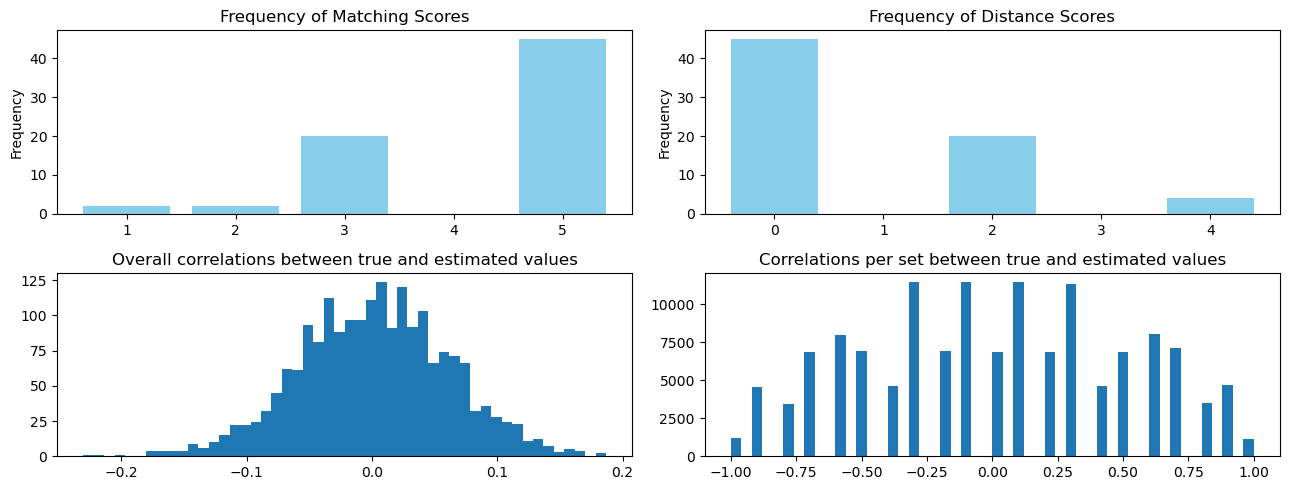

In [11]:
plot_results(trace1, ppc1)

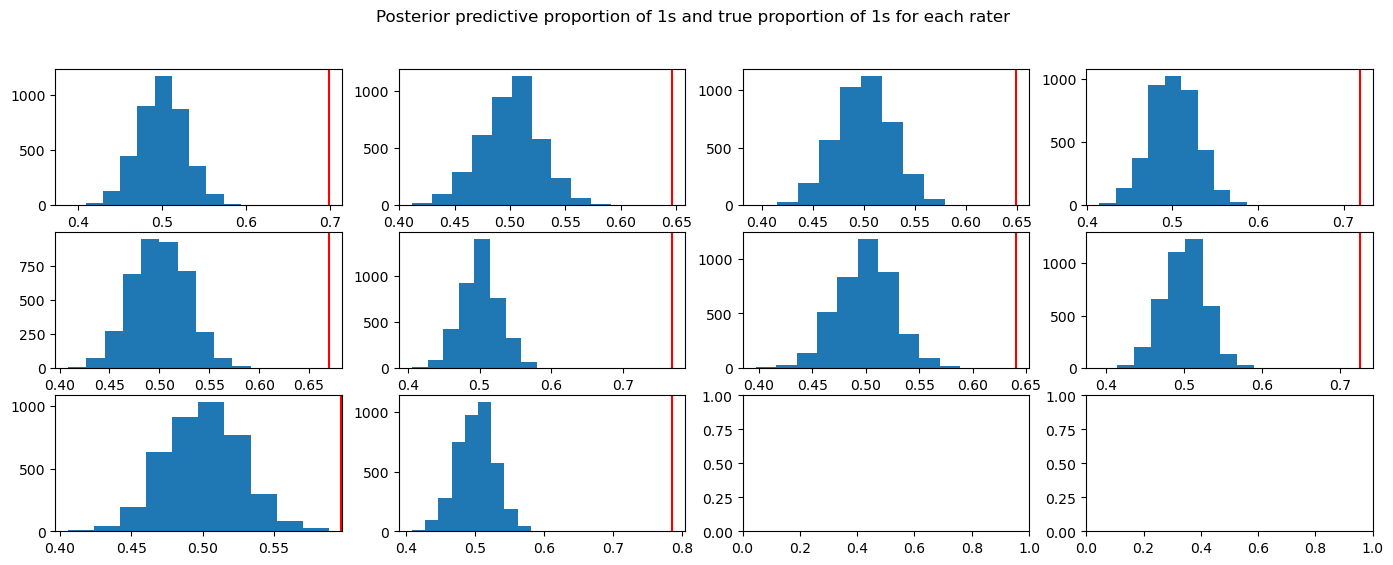

In [12]:
plot_binary_ppc(ppc1)

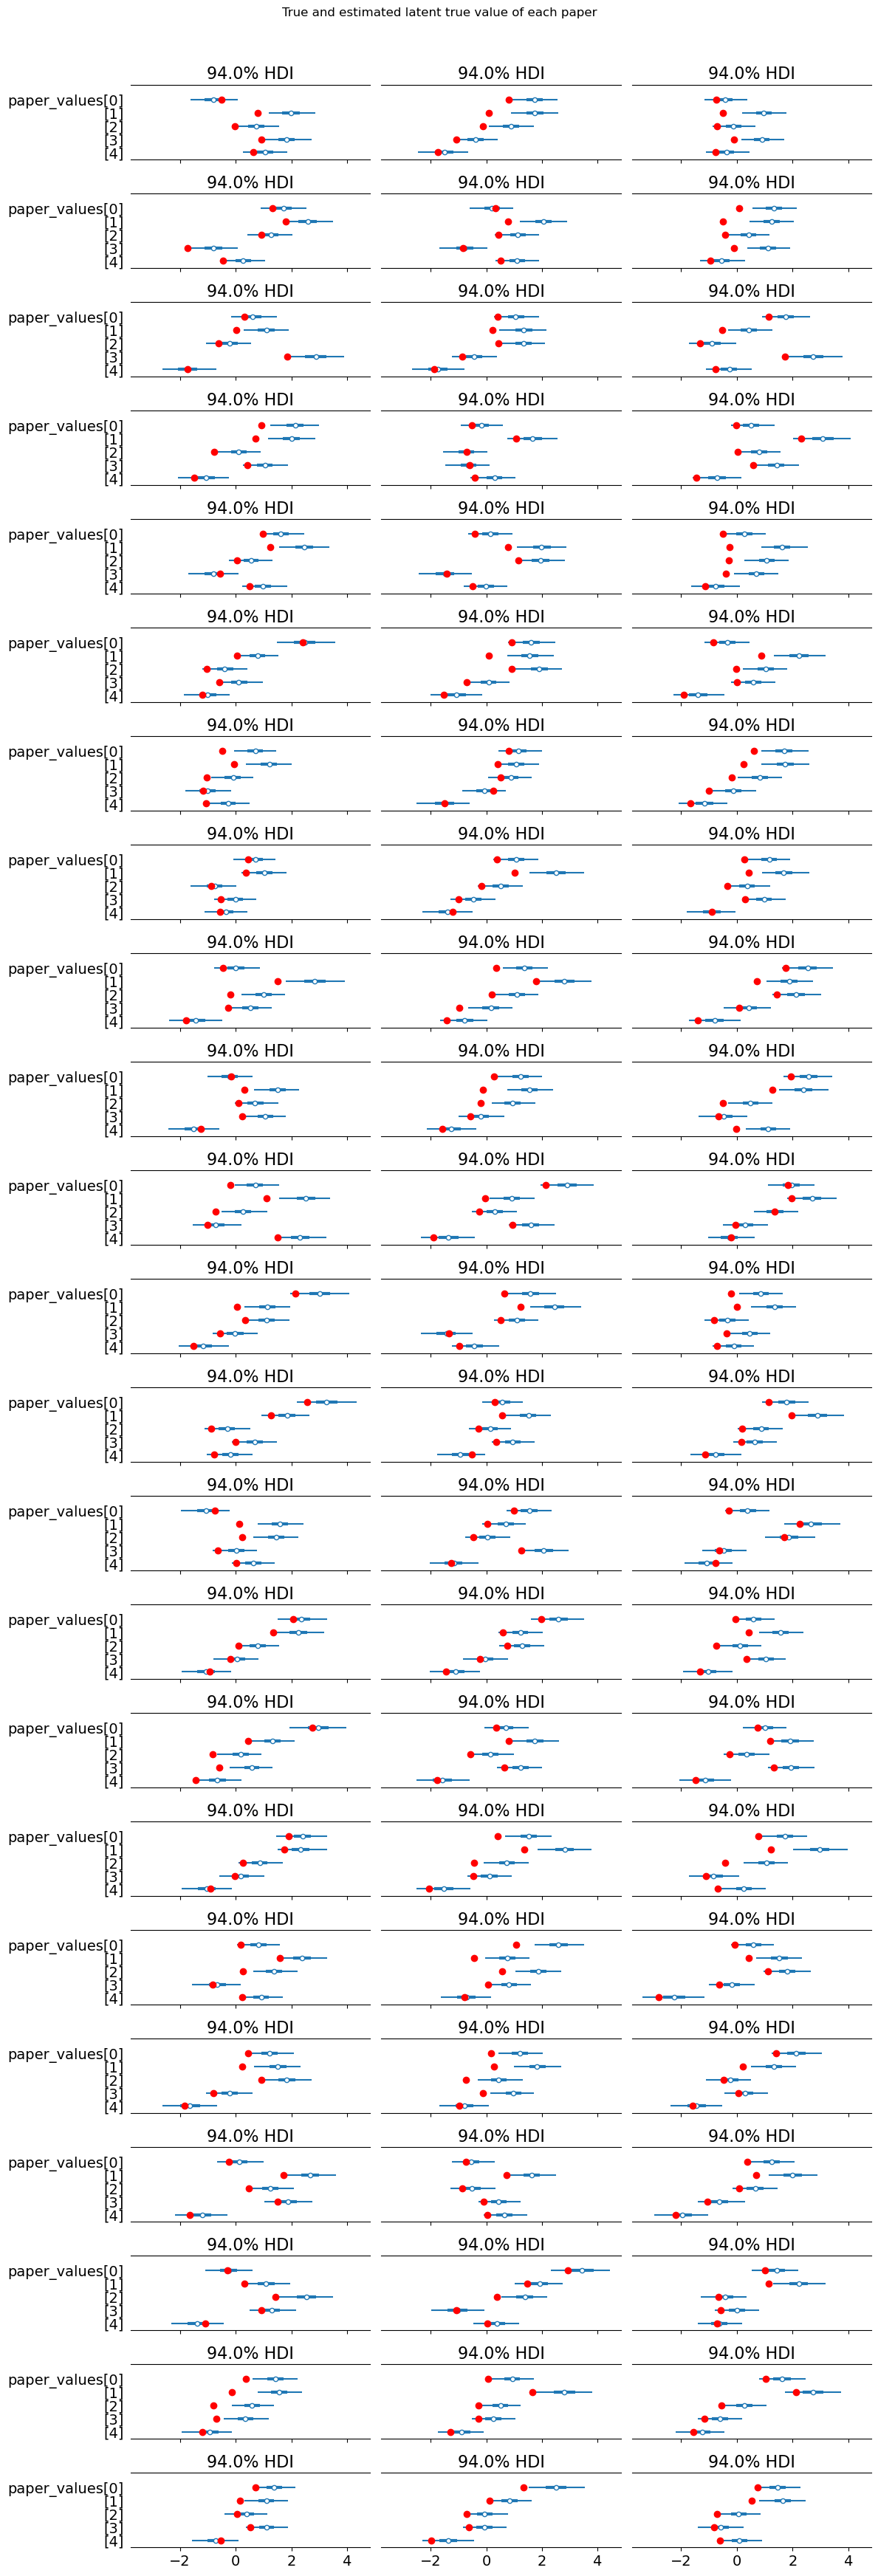

In [13]:
plot_paper_values(trace1, true_values, 'paper_values')


# Model 3: add linear model with fields parameter

In [14]:
with pm.Model() as model3:

    # field parameter, one for each target field
    fields = pm.Normal('fields',0, 1,shape = (K))

    # an intercept for each paper
    paper_intercepts = pm.Normal('paper_intercepts',0,1, shape = (B,K))

    # the linear model
    paper_values = pm.Deterministic('paper_values', paper_intercepts + fields[fields_presence])

    # for each set, there are J ratings, so tile these priors
    mu = pm.Deterministic('mu', pt.tile(paper_values[:,pt.newaxis,:],(1,J,1)))

    # reorder with the rank data such that the model knows which latent value the rater thought is higher/lower.
    reordered_mu = pm.Deterministic('reordered_mu', pt.take_along_axis(mu, rank_data, axis = -1))

    # estimate the value that each rater estimated each paper to have
    latent = pm.Normal('latent',
                       mu=reordered_mu,
                       sigma=1, # using sd does not work yet
                       transform=Ordered(), 
                       shape=(B,J,K),
                       # have to set test value to avoid issues with negative numbers
                       testval=np.tile(np.tile(np.arange(K), (B, 1))[:, np.newaxis, :], (1, J, 1))) 

    # put the papers back in the original order in order to feed the latent values into the bernoulli for the binary scoring
    latent_reshaped = pt.take_along_axis(latent, rank_data_argsort, axis = -1)

    # the binary ranking process
    binary = pm.Bernoulli('binary',logit_p = latent_reshaped, observed = binary_data)

    # sample from the priors to look at them
    pr3 = pm.sample_prior_predictive()

Sampling: [binary, fields, latent, paper_intercepts]


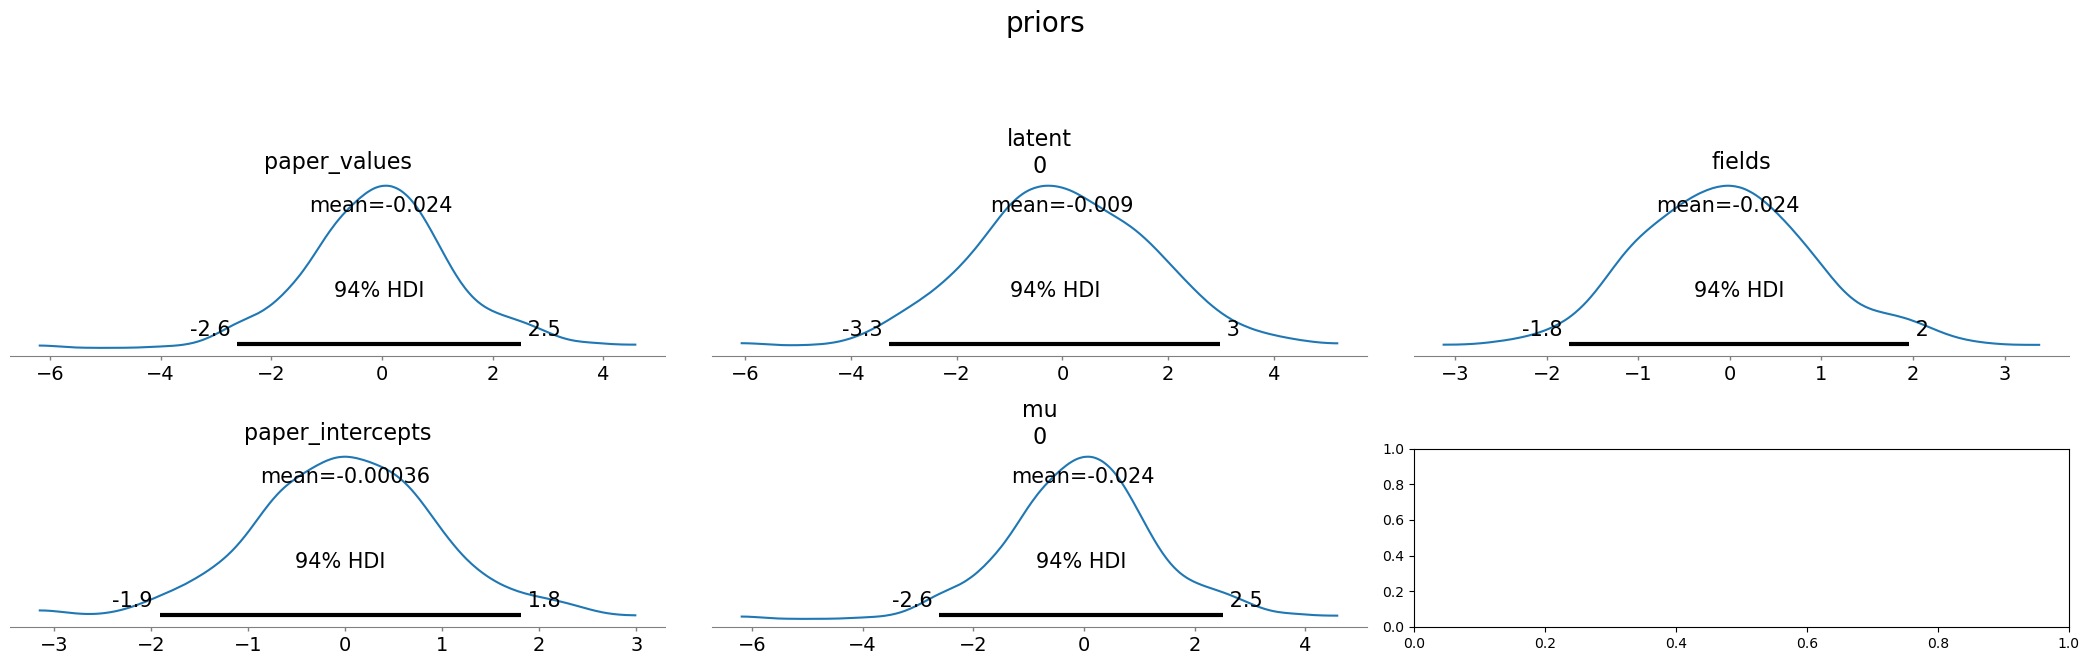

In [15]:
plot_priors(pr3, ['paper_values','latent','fields', 'paper_intercepts','mu'])

In [16]:
with model3:
    trace3 = pm.sample(1000,idata_kwargs={"log_likelihood": True},target_accept = 0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [fields, paper_intercepts, latent]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 547 seconds.


In [17]:
trace3.to_netcdf("...\SimulTrace3.nc")

'C:\\Users\\conix\\Documents\\IIH_localtraces\\SimulTrace3.nc'

In [18]:
trace3 = az.from_netcdf("...\SimulTrace3.nc")

In [19]:
with model3:
    ppc3 = pm.sample_posterior_predictive(trace3, var_names = ['paper_values','binary'])

Sampling: [binary, latent]


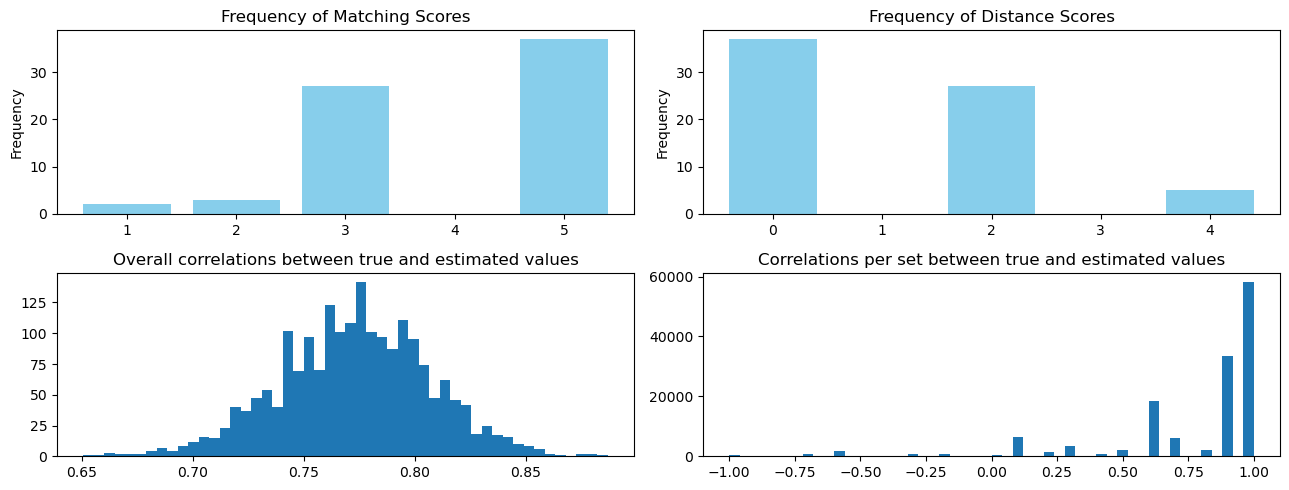

In [20]:
plot_results(trace3, ppc3)

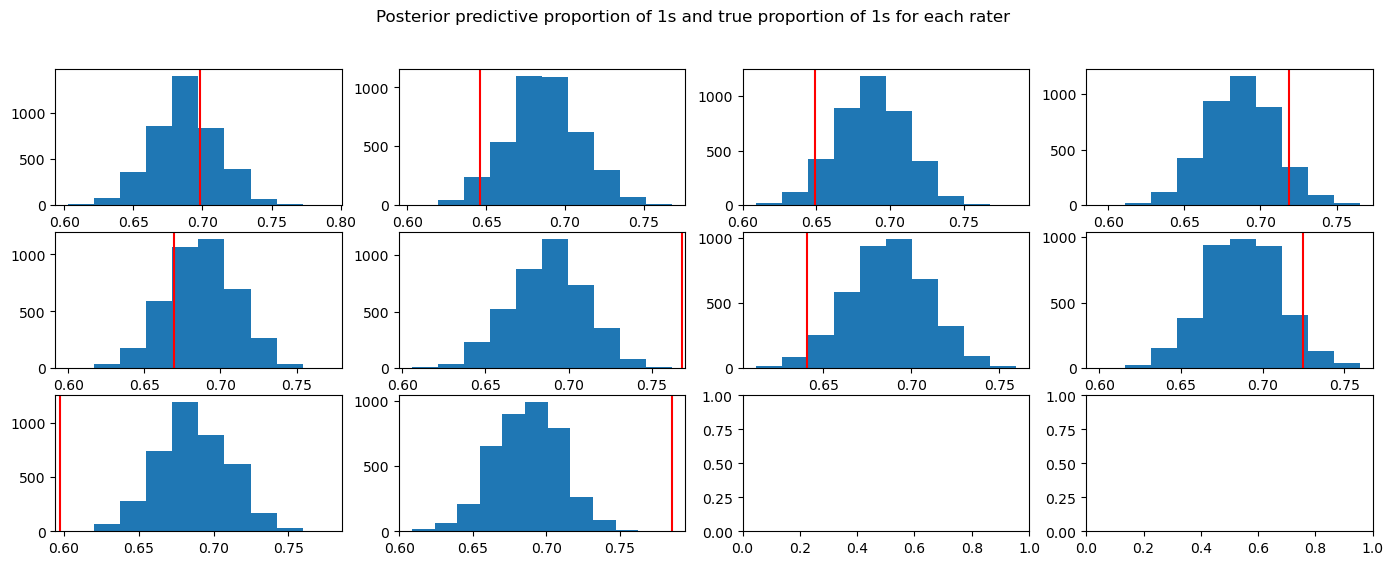

In [21]:
plot_binary_ppc(ppc3)

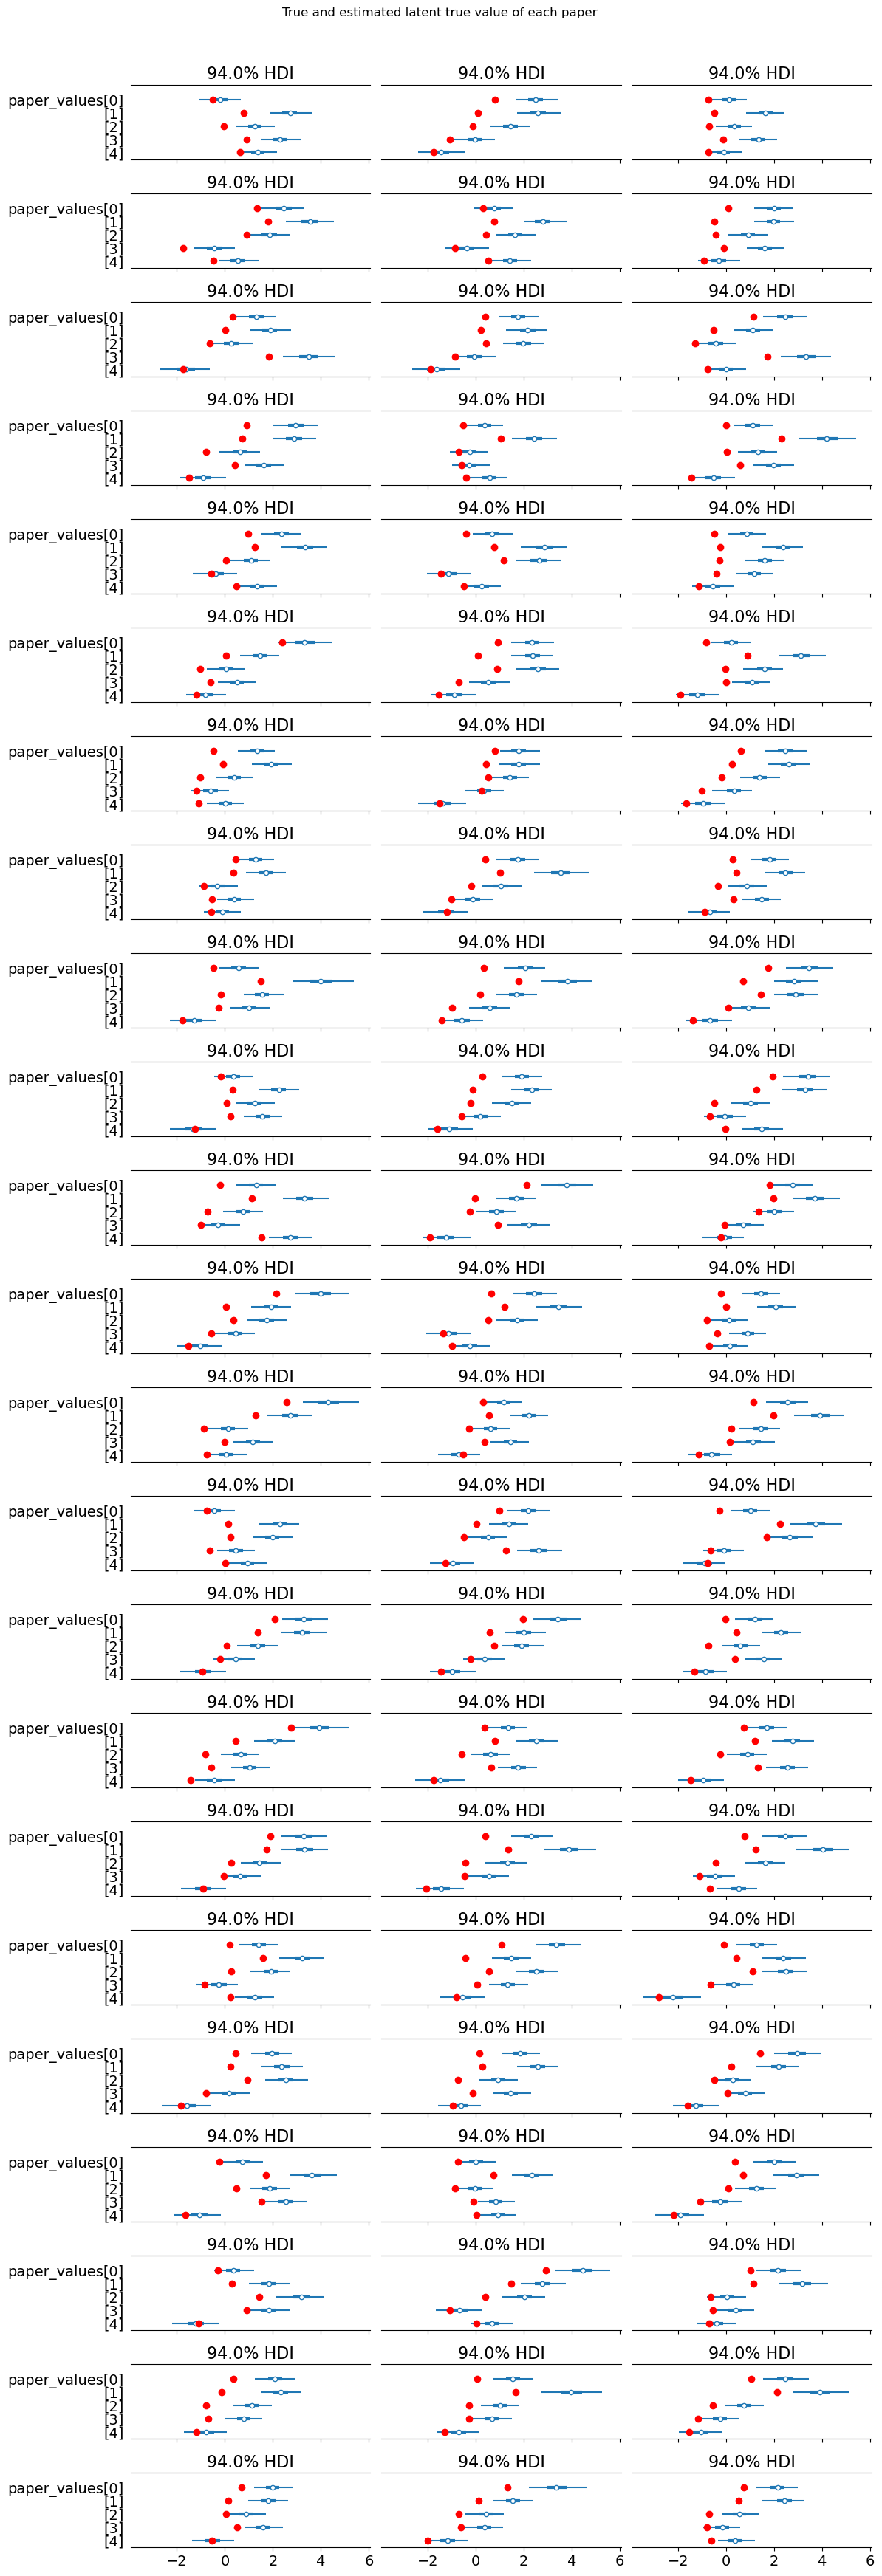

In [22]:
plot_paper_values(trace3, true_values, 'paper_values')


# Model4: add content to the linear model

We expect that the true societal relevance of a paper is higher if it is about certain topics such as ethics, wellbeing, health,... We add parameters for these to the linear model that serves as the mean for the rater estimates.



In [23]:
with pm.Model() as model4:

    # add the parameters for content to the linear model
    content = pm.Normal('content',0,1,shape = (len(content_params))) # priors for the content
    dot_prod = pt.dot(content_presence, content) # add in the inideces for the content
    dot_prod_reshaped = dot_prod.reshape((B,K)) # reshape to fit with the rest of the data

    fields = pm.Normal('fields',0, 1,shape = (K))
    
    paper_intercepts = pm.Normal('paper_intercepts',0,1, shape = (B,K))

    # add the content parameters to the linear model
    paper_values = pm.Deterministic('paper_values', paper_intercepts + fields[fields_presence]+ dot_prod_reshaped )


    mu = pm.Deterministic('mu', pt.tile(paper_values[:,pt.newaxis,:],(1,J,1)) )
    reordered_mu = pm.Deterministic('reordered_mu', pt.take_along_axis(mu, rank_data, axis = -1))
       
    latent = pm.Normal('latent',
                       mu=reordered_mu,
                       sigma=1, # using sd does not work yet
                       transform=Ordered(), 
                       shape=(B,J,K),
                       # have to set test value to avoid issues with negative numbers
                       testval=np.tile(np.tile(np.arange(K), (B, 1))[:, np.newaxis, :], (1, J, 1))) 
    
    latent_reshaped = pt.take_along_axis(latent, rank_data_argsort, axis = -1)
    
    binary = pm.Bernoulli('binary',logit_p = latent_reshaped, observed = binary_data)
    pr4 = pm.sample_prior_predictive()

Sampling: [binary, content, fields, latent, paper_intercepts]


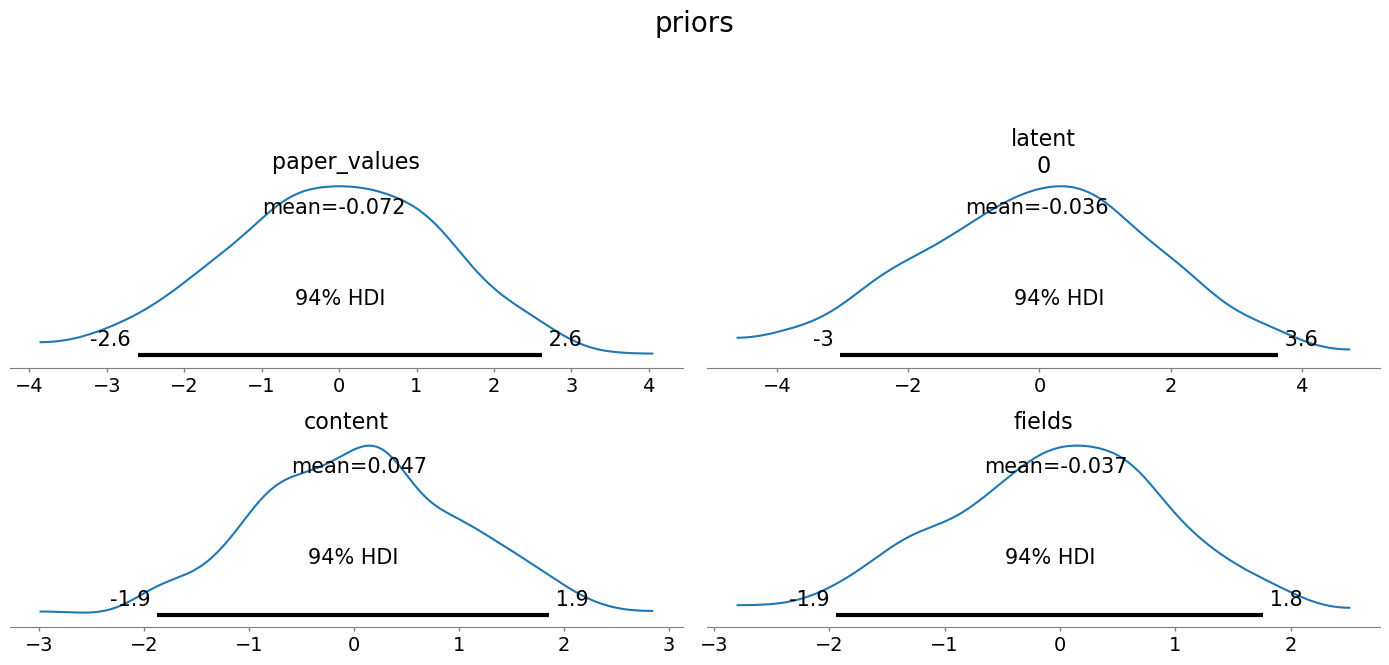

In [24]:
plot_priors(pr4, ['paper_values','latent','content','fields'])

In [42]:
with model4:
    trace4 = pm.sample(1000,idata_kwargs={"log_likelihood": True},target_accept = 0.8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [content, fields, paper_intercepts, latent]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 379 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [43]:
trace4.to_netcdf("...\SimulTrace4.nc")

'C:\\Users\\conix\\Documents\\IIH_localtraces\\SimulTrace4.nc'

In [44]:
trace4 = az.from_netcdf("...\SimulTrace4.nc")

In [45]:
with model4:
    ppc4 = pm.sample_posterior_predictive(trace4, var_names = ['paper_values','binary'])

Sampling: [binary, latent]


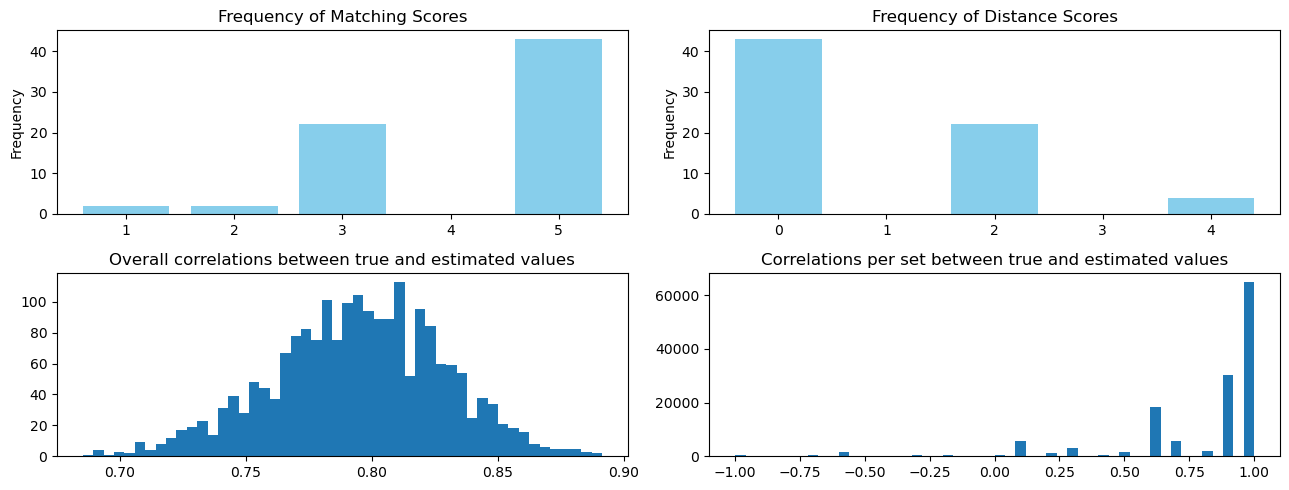

In [46]:
plot_results(trace4, ppc4)

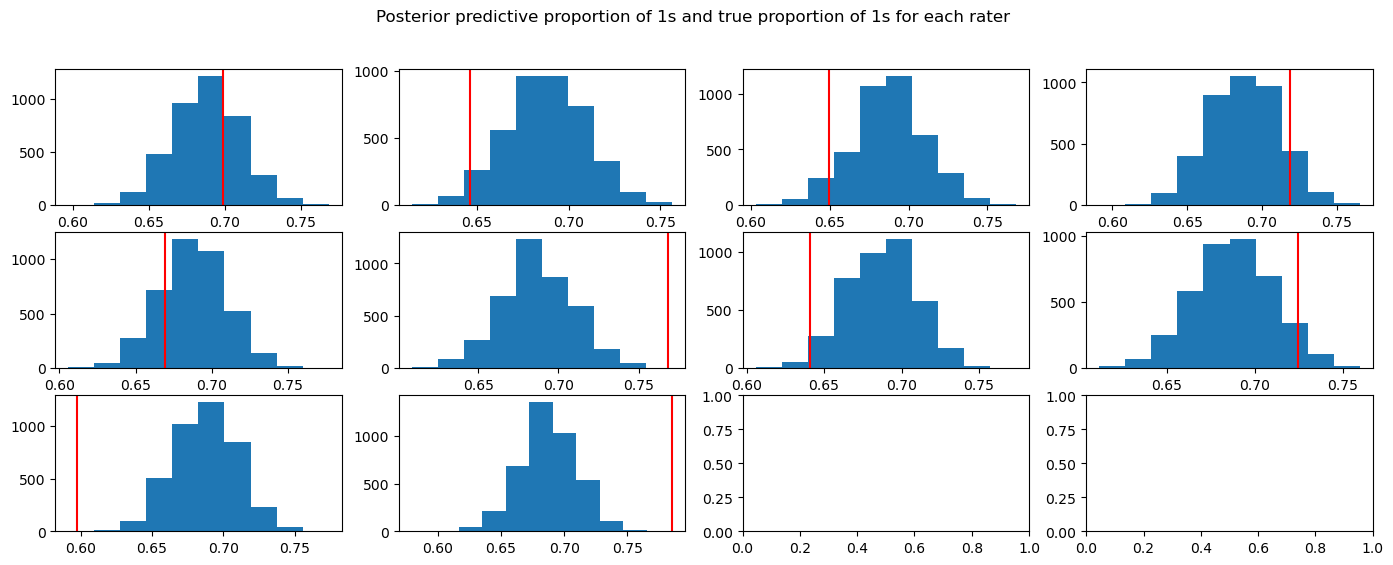

In [47]:
plot_binary_ppc(ppc4)

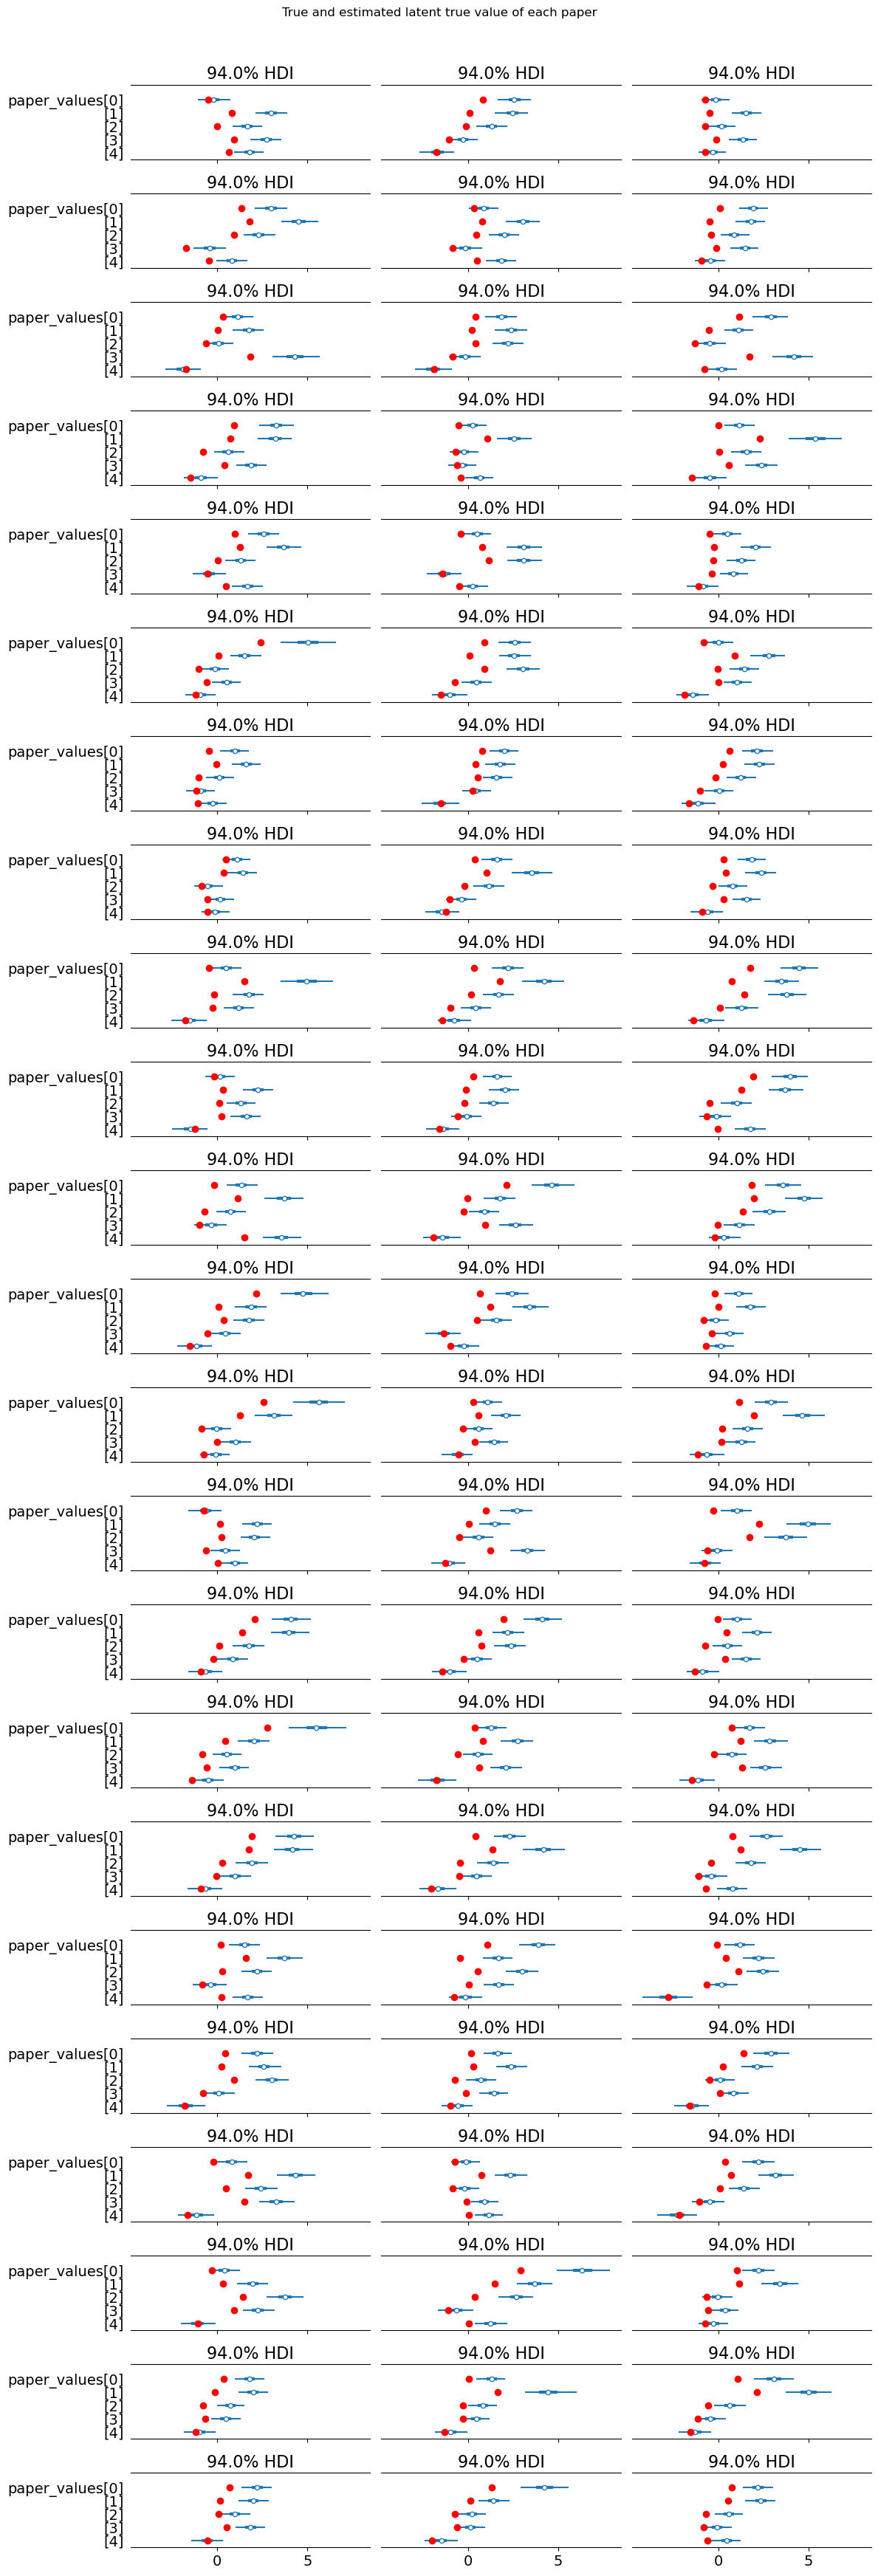

In [48]:
plot_paper_values(trace4, true_values, 'paper_values')


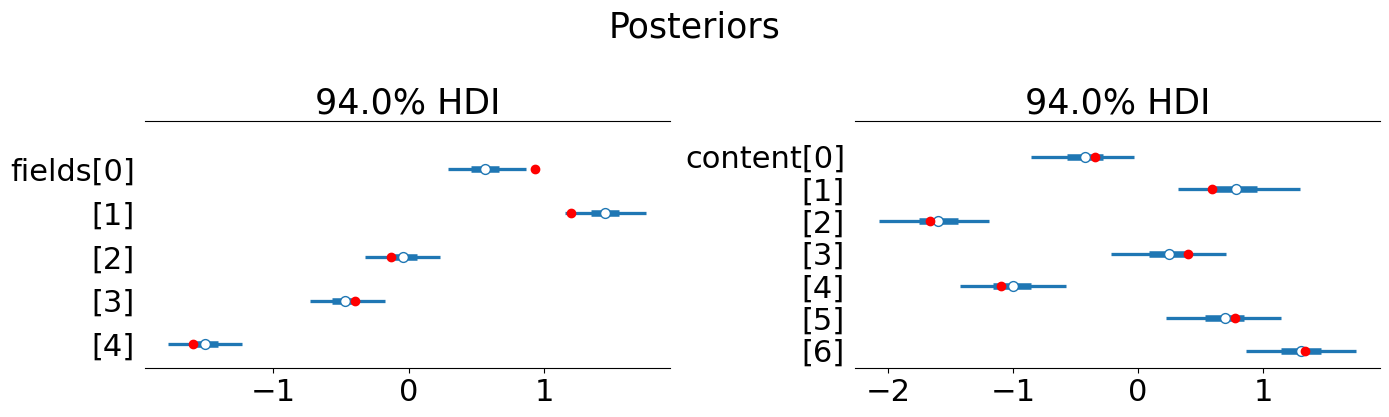

In [49]:
plot_posteriors(trace4, ['fields','content'])

# Model5: add strictness

We noticed in a previous study, and in the pilot of this study, that raters have very different thresholds for giving a '1'. We try to model this difference as a strictness parameter that varies between raters. 


In [50]:
with pm.Model() as model5:

    content = pm.Normal('content',0,1,shape = (len(content_params))) # priors for the content
    dot_prod = pt.dot(content_presence, content) # add in the inideces for the content
    dot_prod_reshaped = dot_prod.reshape((B,K)) # reshape to fit with the rest of the data

    fields = pm.Normal('fields',0, 1,shape = (K))
    
    paper_intercepts = pm.Normal('paper_intercepts',0,1, shape = (B,K))

    paper_values = pm.Deterministic('paper_values', paper_intercepts + fields[fields_presence]+ dot_prod_reshaped )


    mu = pm.Deterministic('mu', pt.tile(paper_values[:,pt.newaxis,:],(1,J,1)) )
    reordered_mu = pm.Deterministic('reordered_mu', pt.take_along_axis(mu, rank_data, axis = -1))
    
    latent = pm.Normal('latent',
                       mu=reordered_mu,
                       sigma=1, # using sd does not work yet
                       transform=Ordered(), 
                       shape=(B,J,K),
                       # have to set test value to avoid issues with negative numbers
                       testval=np.tile(np.tile(np.arange(K), (B, 1))[:, np.newaxis, :], (1, J, 1))) 
    
    latent_reshaped = pt.take_along_axis(latent, rank_data_argsort, axis = -1)


    # add a parameter for strictness, one for each rater
    strictness = pm.Normal('strictness',0,1,shape = (1,J,1))

    # the strictness parameter is added to the latent estimate of the paper value. Together these serve as the probability of observing a 1.
    # hence, a high strictness value means that raters aren't strict.
    binary = pm.Bernoulli('binary',logit_p = latent_reshaped + strictness, observed = binary_data)
    pr5 = pm.sample_prior_predictive()

Sampling: [binary, content, fields, latent, paper_intercepts, strictness]


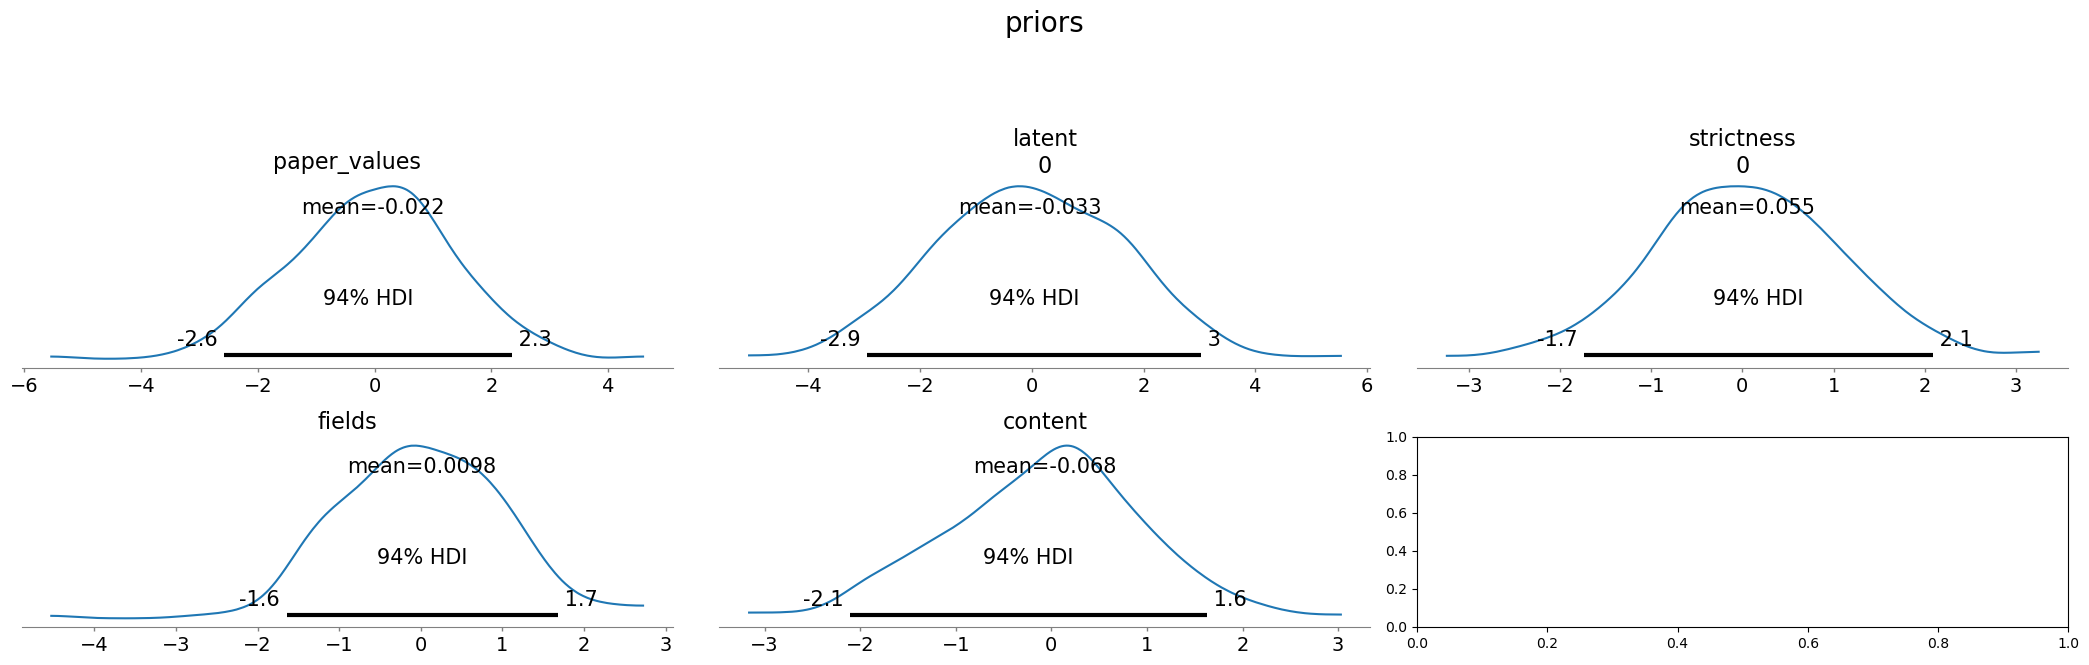

In [51]:
plot_priors(pr5, ['paper_values','latent','strictness','fields','content'])

In [52]:
with model5:
    trace5 = pm.sample(3000,idata_kwargs={"log_likelihood": True},target_accept = 0.8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [content, fields, paper_intercepts, latent, strictness]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 553 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [53]:
with model5:
    ppc5 = pm.sample_posterior_predictive(trace5, var_names = ['paper_values','binary'])

Sampling: [binary, latent]


In [54]:
trace5.to_netcdf("...\SimulTrace5.nc")

'C:\\Users\\conix\\Documents\\IIH_localtraces\\SimulTrace5.nc'

In [55]:
trace5 = az.from_netcdf("...\SimulTrace5.nc")

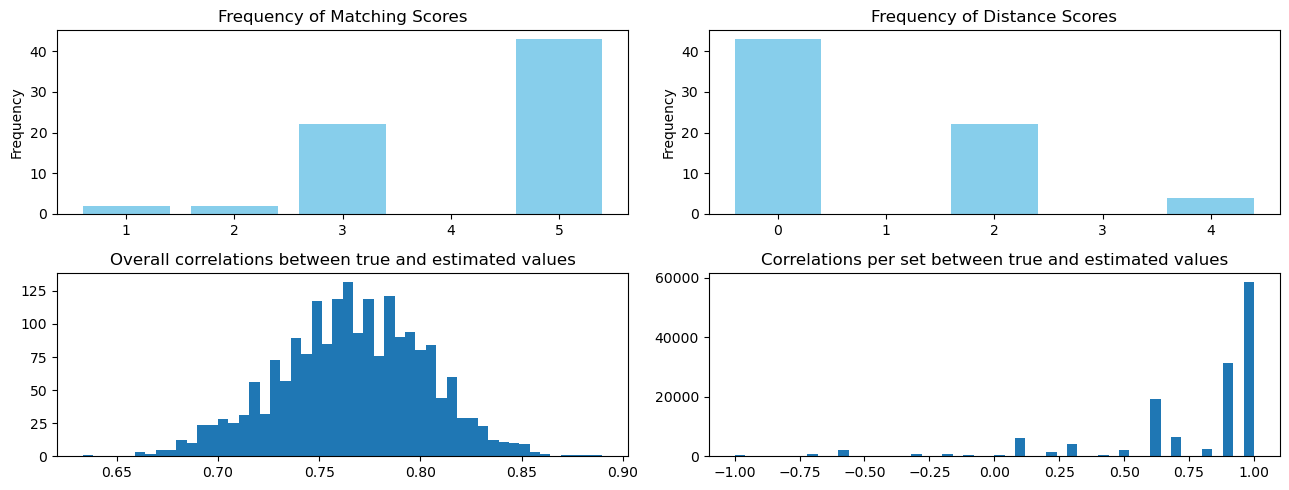

In [56]:
plot_results(trace5, ppc5)

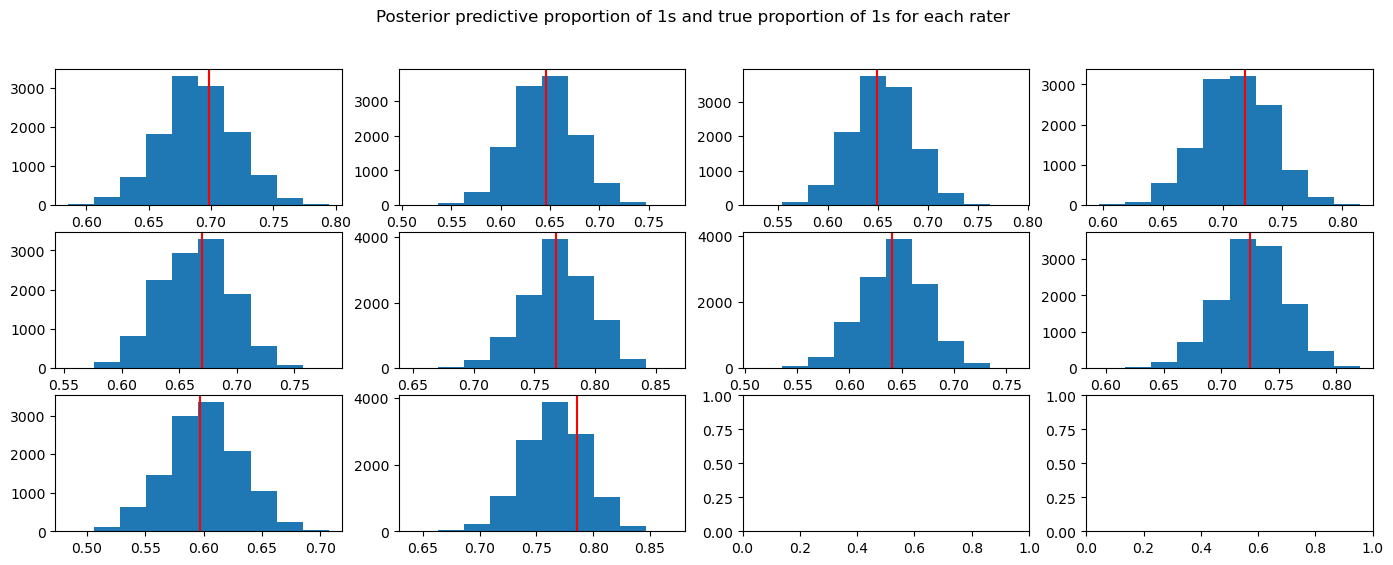

In [57]:
plot_binary_ppc(ppc5)

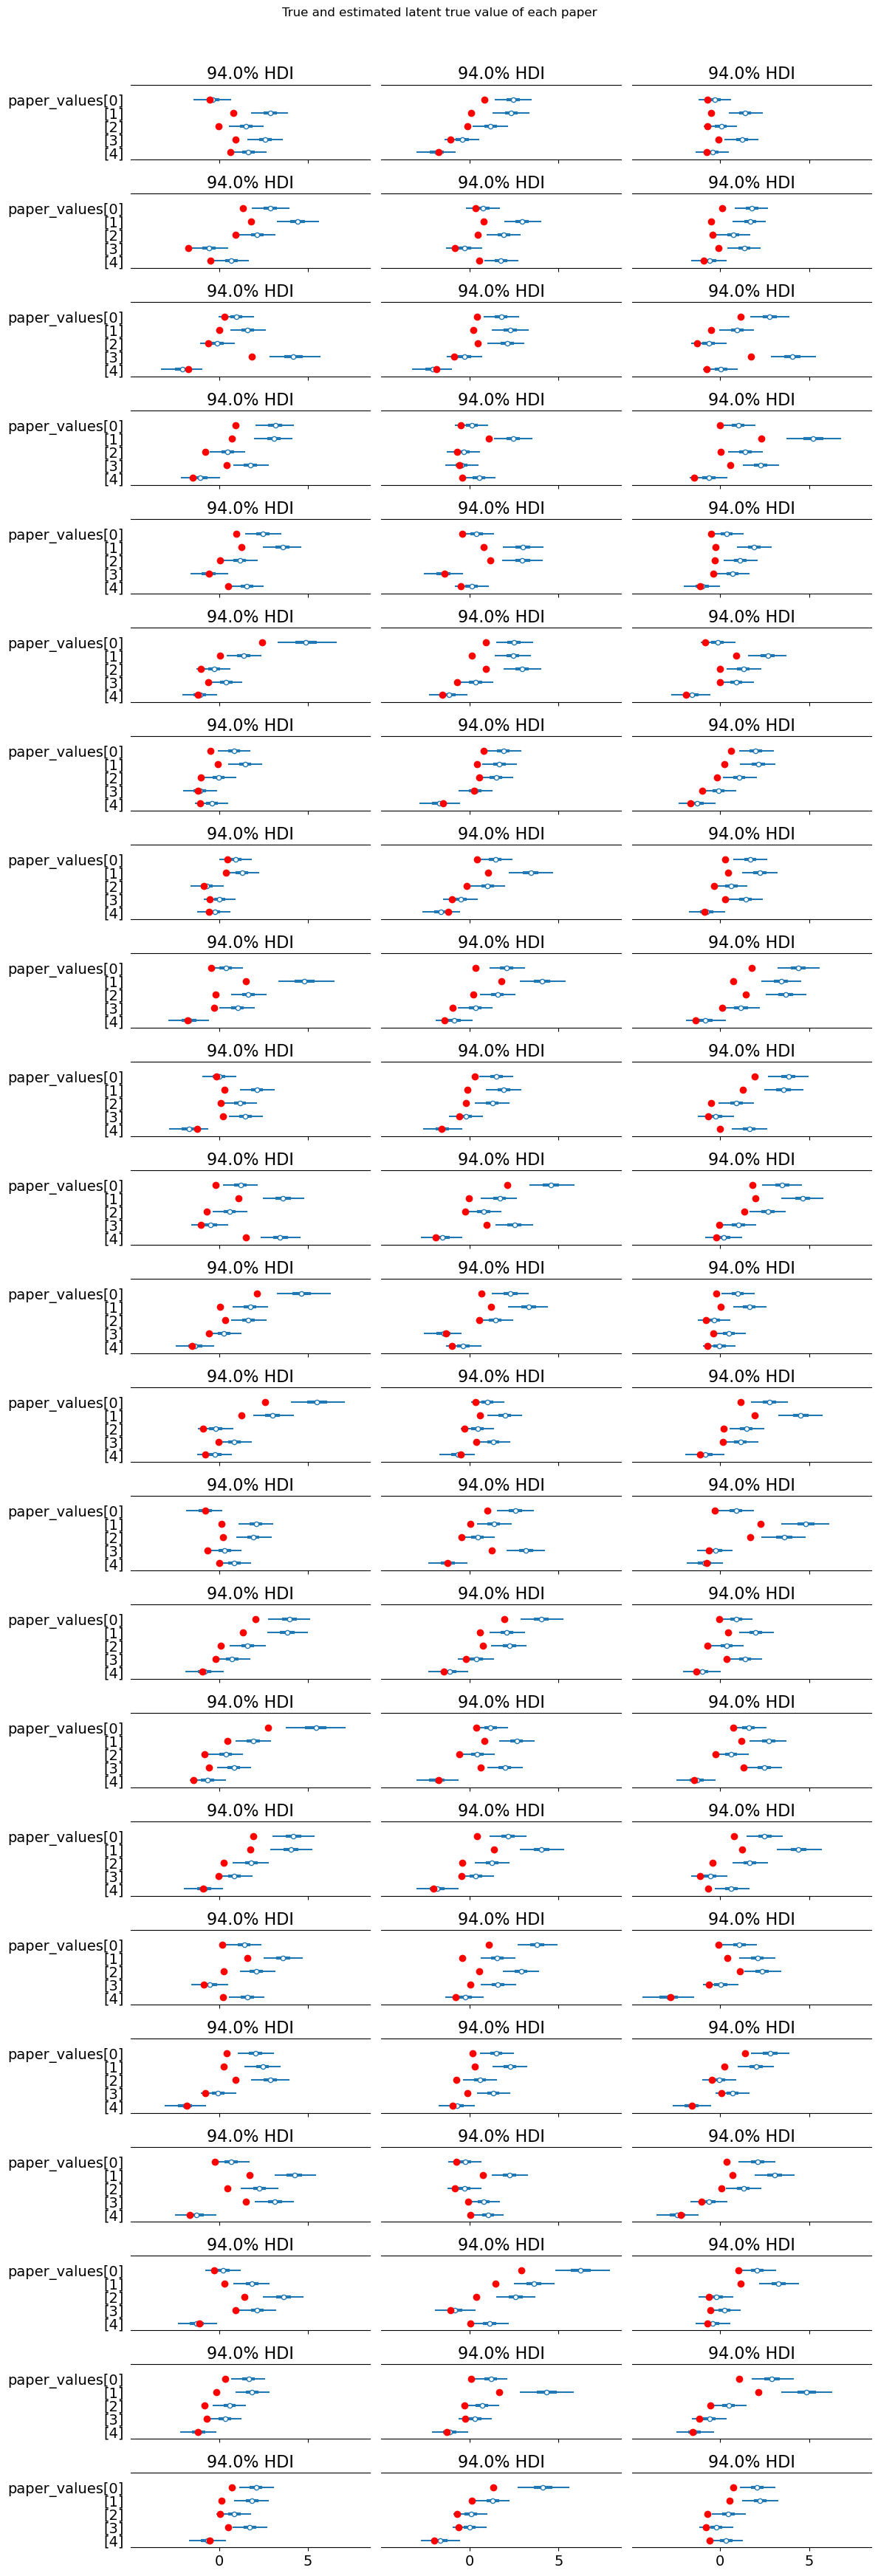

In [58]:
plot_paper_values(trace5, true_values, 'paper_values')


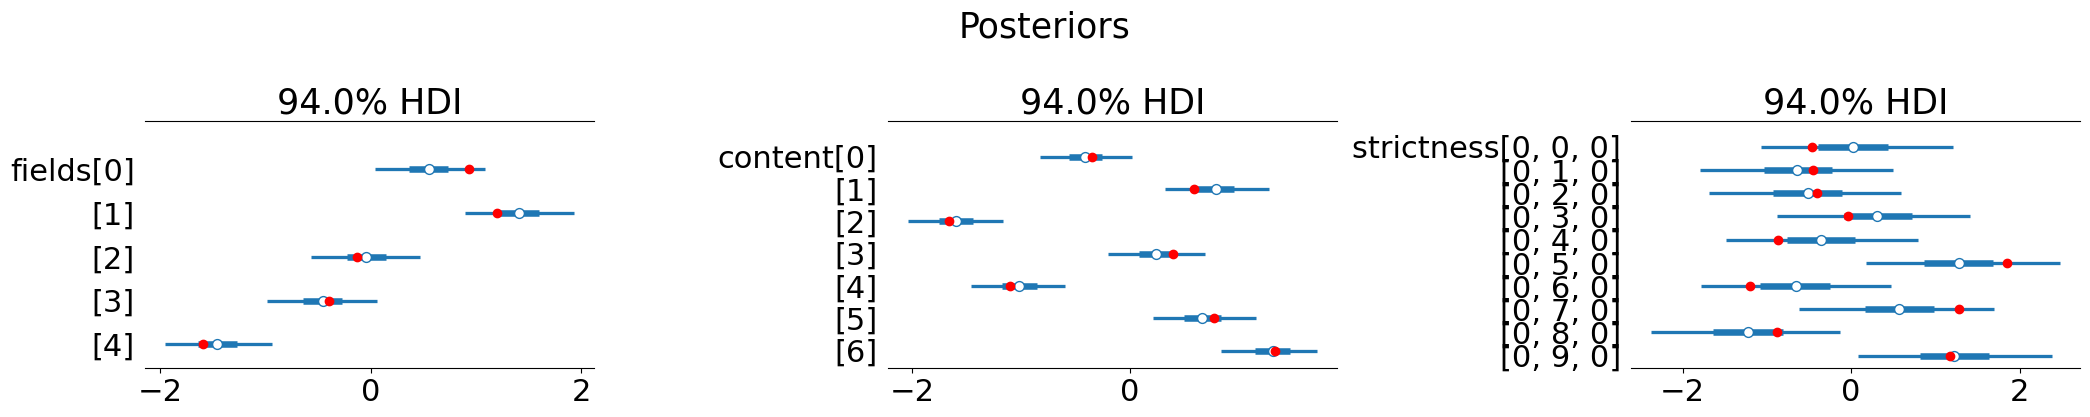

In [59]:
plot_posteriors(trace5, ['fields','content','strictness'])

# Model6: add chauvinism 

We hypothesize that raters tend to rate papers from their own field differently. We add this to the linear model.


In [60]:
with pm.Model() as model6:

    
    content = pm.Normal('content',0,1,shape = (len(content_params))) # priors for the content
    dot_prod = pt.dot(content_presence, content) # add in the inideces for the content
    dot_prod_reshaped = dot_prod.reshape((B,K)) # reshape to fit with the rest of the data

    fields = pm.Normal('fields',0, 1,shape = (K))
    
    paper_intercepts = pm.Normal('paper_intercepts',0,1, shape = (B,K))

    paper_values = pm.Deterministic('paper_values', paper_intercepts + fields[fields_presence]+ dot_prod_reshaped )

    # add a chauvinism parameter, one for each rater.
    chauvinism = pm.Normal('chauvinism',0, 1, shape=(1,J,1)) 

    # add the chauvinism parameter to the linear model (and index it to make sure it works for the correct papers)
    mu = pm.Deterministic('mu', pt.tile(paper_values[:,pt.newaxis,:],(1,J,1)) + (chauv_array * chauvinism))

    reordered_mu = pm.Deterministic('reordered_mu', pt.take_along_axis(mu, rank_data, axis = -1))

    latent = pm.Normal('latent',
                       mu=reordered_mu,
                       sigma=1, 
                       transform=Ordered(), 
                       shape=(B,J,K),
                       # have to set test value to avoid issues with negative numbers
                       testval=np.tile(np.tile(np.arange(K), (B, 1))[:, np.newaxis, :], (1, J, 1))) 

    latent_reshaped = pt.take_along_axis(latent, rank_data_argsort, axis = -1)


    strictness = pm.Normal('strictness',0,1,shape = (1,J,1))
    binary = pm.Bernoulli('binary',logit_p = latent_reshaped + strictness, observed = binary_data)
    pr6 = pm.sample_prior_predictive()

Sampling: [binary, chauvinism, content, fields, latent, paper_intercepts, strictness]


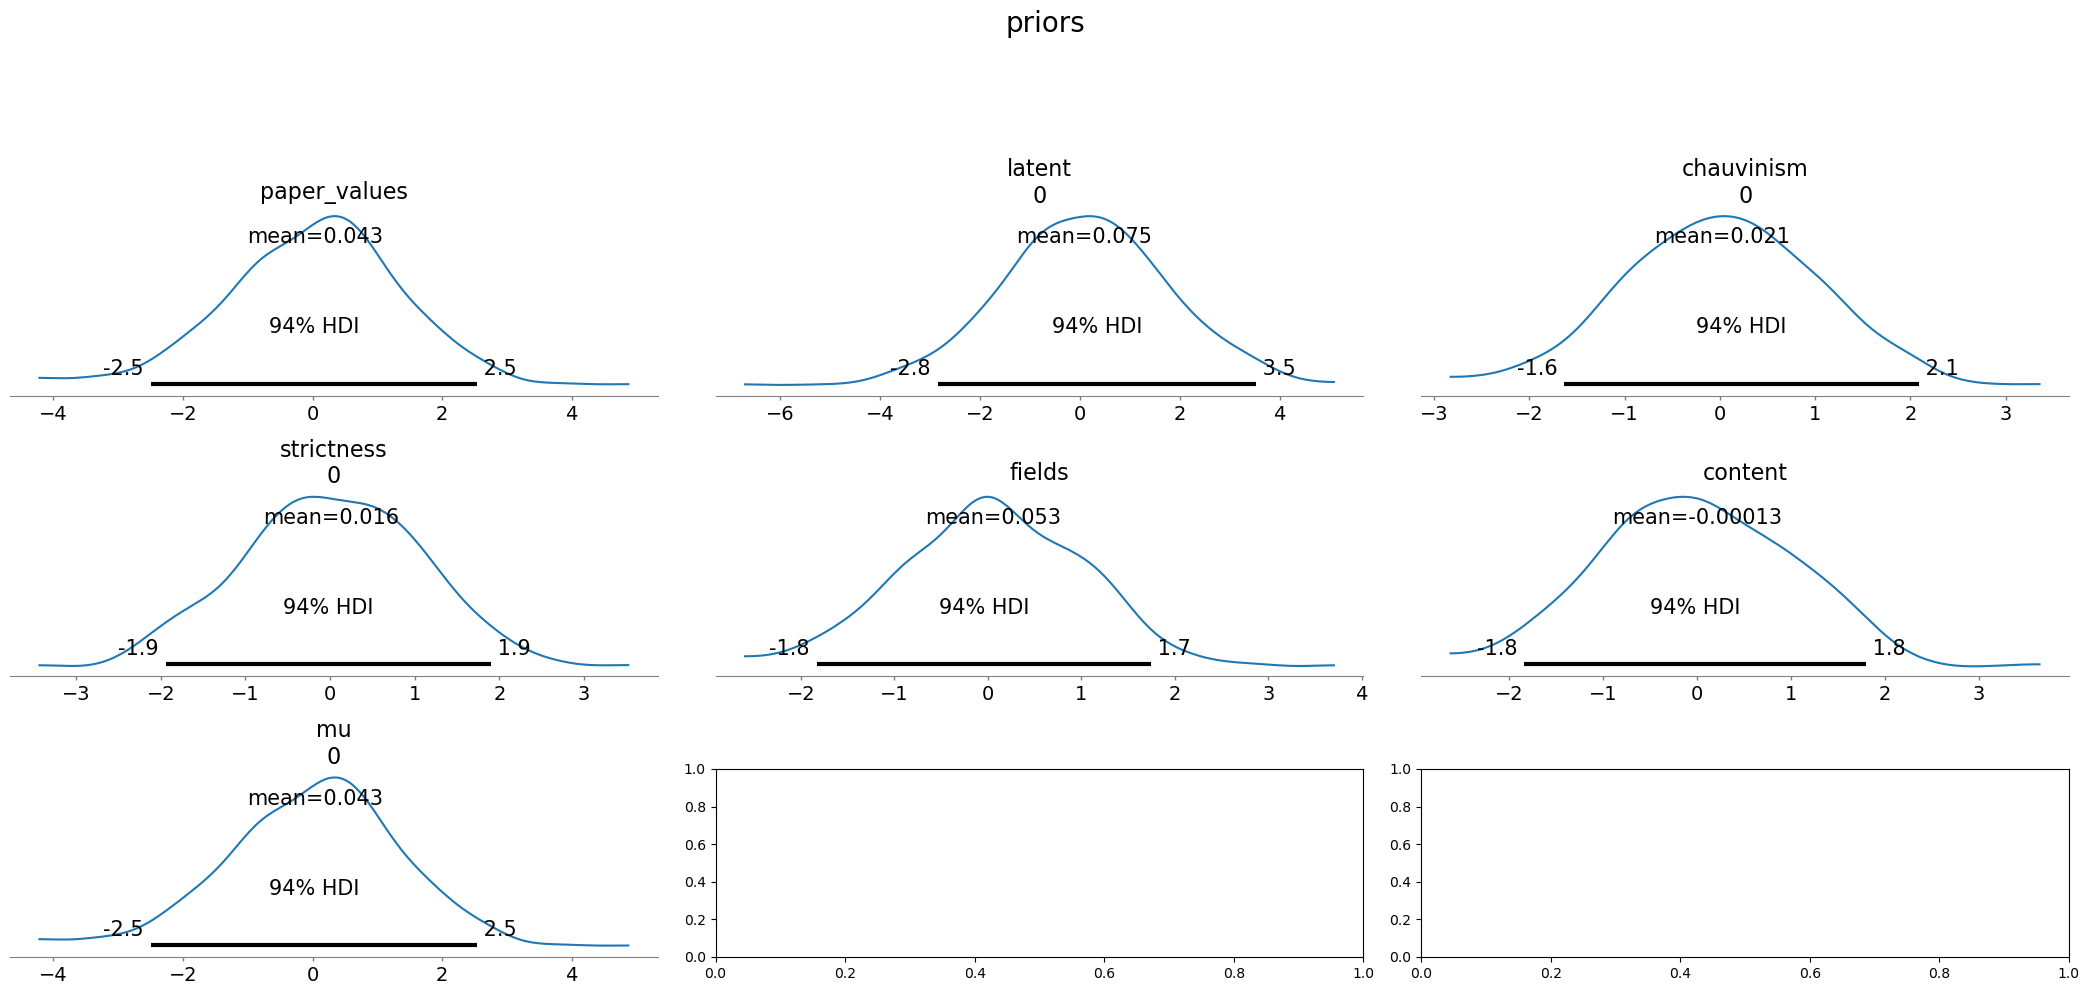

In [61]:
plot_priors(pr6, ['paper_values','latent','chauvinism','strictness','fields','content', 'mu'])

In [62]:
with model6:
    trace6 = pm.sample(4000,idata_kwargs={"log_likelihood": True},target_accept = 0.8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [content, fields, paper_intercepts, chauvinism, latent, strictness]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 1934 seconds.


In [63]:
trace6.to_netcdf("...\SimulTrace6.nc")

'C:\\Users\\conix\\Documents\\IIH_localtraces\\SimulTrace6.nc'

In [64]:
trace6 = az.from_netcdf("...\SimulTrace6.nc")

In [65]:
with model6:
    ppc6 = pm.sample_posterior_predictive(trace6, var_names = ['paper_values','binary'])

Sampling: [binary, latent]


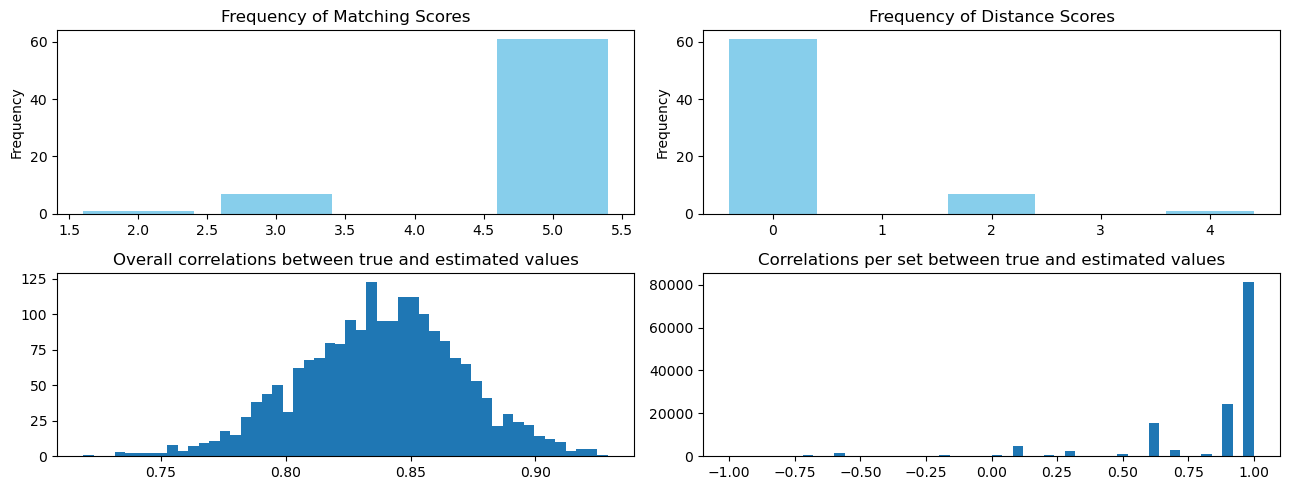

In [66]:
plot_results(trace6, ppc6)

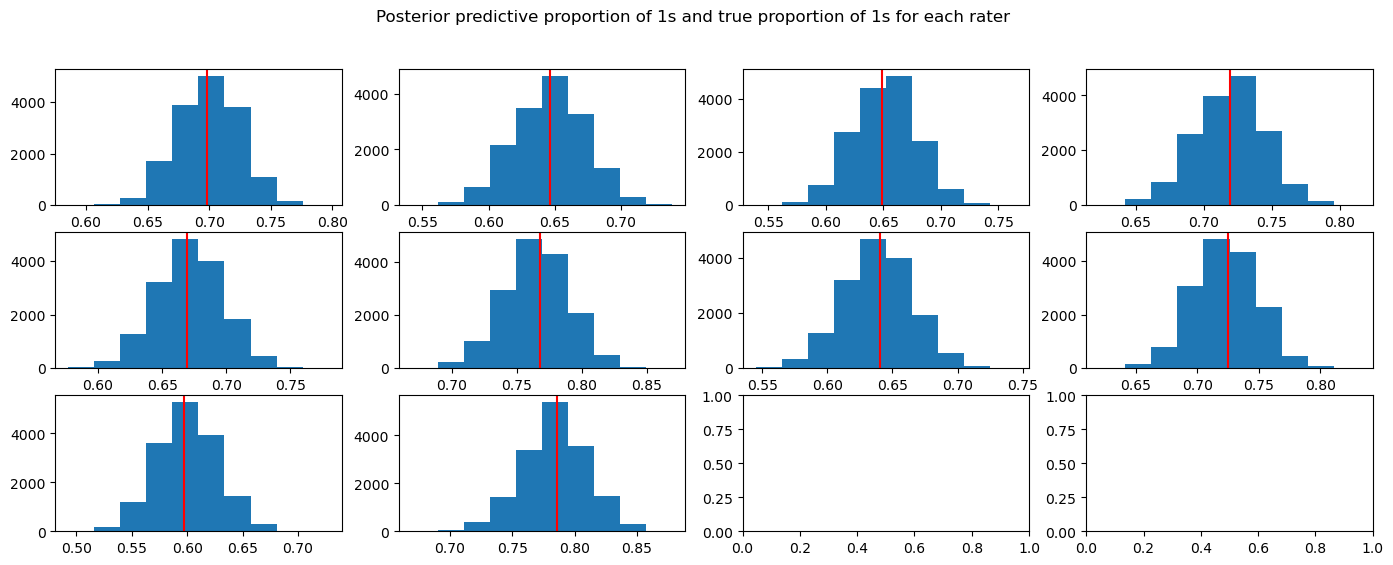

In [67]:
plot_binary_ppc(ppc6)

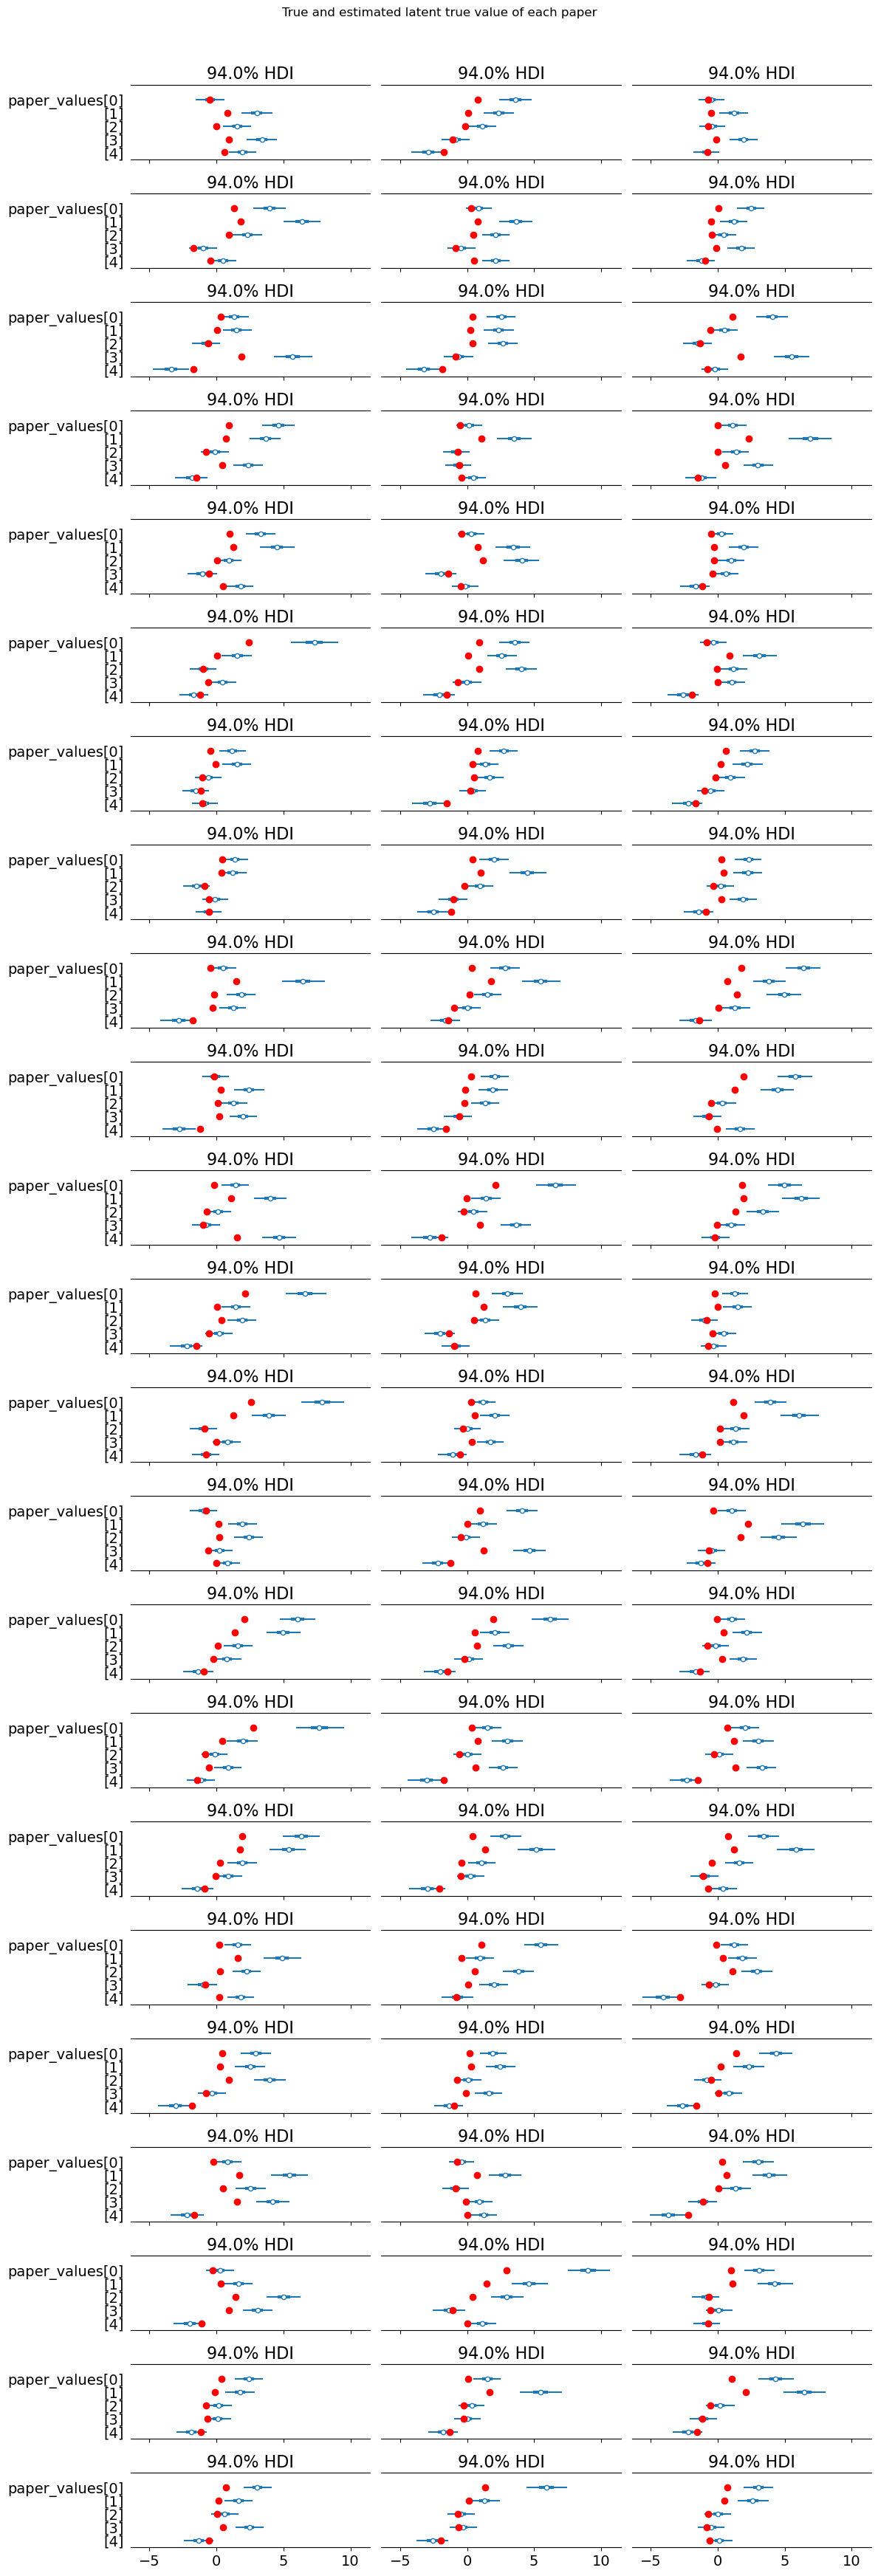

In [68]:
plot_paper_values(trace6, true_values, 'paper_values')


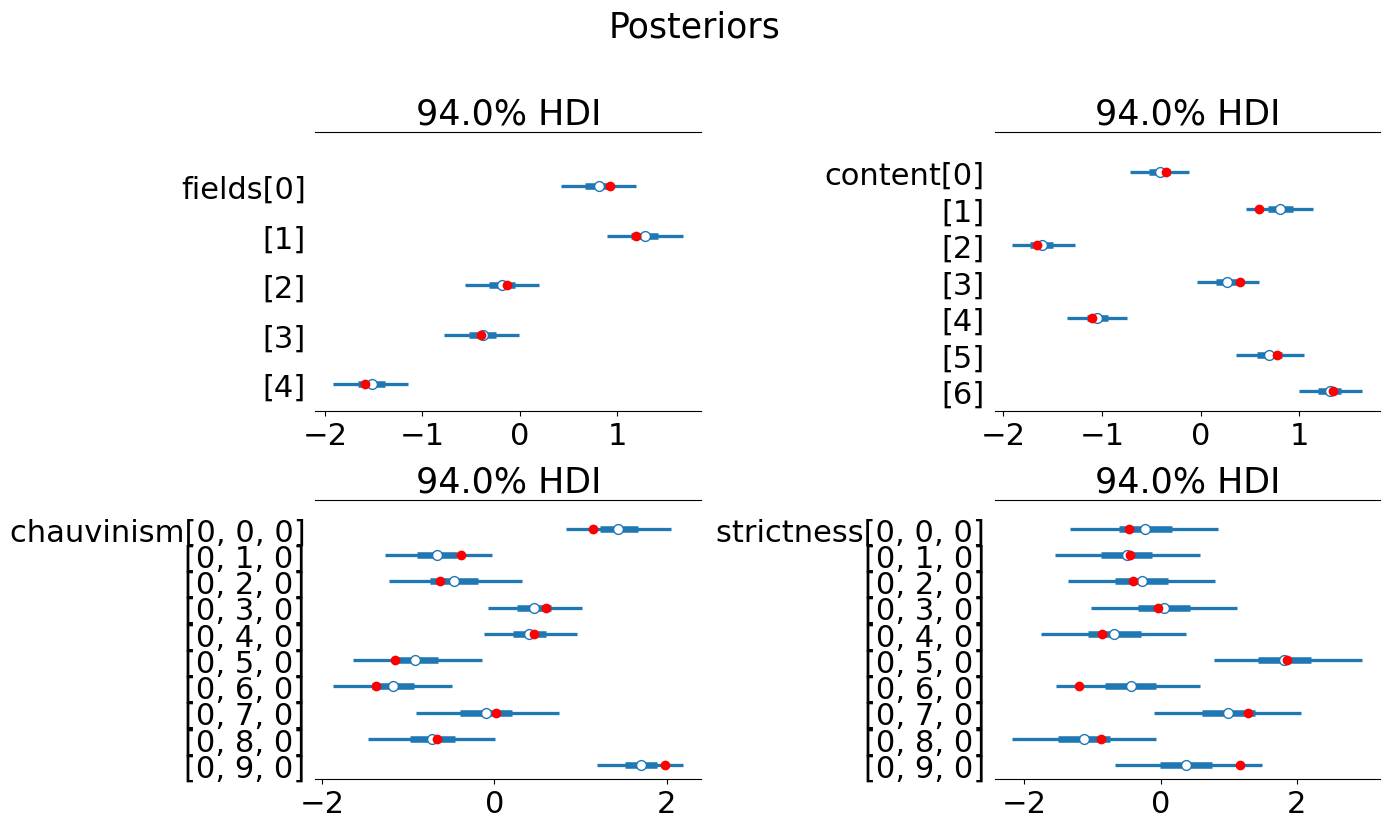

In [69]:
plot_posteriors(trace6, ['fields','content','chauvinism','strictness'])

# Model 7: Add parameter for SD of the estimates

In [70]:
with pm.Model() as model7:
    
    content = pm.Normal('content',0,1,shape = (len(content_params))) # priors for the content
    dot_prod = pt.dot(content_presence, content) # add in the inideces for the content
    dot_prod_reshaped = dot_prod.reshape((B,K)) # reshape to fit with the rest of the data

    fields = pm.Normal('fields',0, 1,shape = (K))
    
    paper_intercepts = pm.Normal('paper_intercepts',0,1, shape = (B,K))

    paper_values = pm.Deterministic('paper_values', paper_intercepts + fields[fields_presence]+ dot_prod_reshaped )

    chauvinism = pm.Normal('chauvinism',0, 1, shape=(1,J,1)) 

    mu = pm.Deterministic('mu', pt.tile(paper_values[:,pt.newaxis,:],(1,J,1)) + (chauv_array * chauvinism))

    reordered_mu = pm.Deterministic('reordered_mu', pt.take_along_axis(mu, rank_data, axis = -1))

    # add a parameter to track the noise on the latent rater estimates
    sigma = pm.Uniform('sigma',0.01,2)

    # add the sigma parameter instead of a fixed sd of 1
    latent = pm.Normal('latent',
                       mu=reordered_mu,
                       sigma=sigma, 
                       transform=Ordered(), 
                       shape=(B,J,K),
                       # have to set test value to avoid issues with negative numbers
                       testval=np.tile(np.tile(np.arange(K), (B, 1))[:, np.newaxis, :], (1, J, 1))) 

    latent_reshaped = pt.take_along_axis(latent, rank_data_argsort, axis = -1)


    strictness = pm.Normal('strictness',0,1,shape = (1,J,1))
    binary = pm.Bernoulli('binary',logit_p = latent_reshaped + strictness, observed = binary_data)
    pr7 = pm.sample_prior_predictive()


Sampling: [binary, chauvinism, content, fields, latent, paper_intercepts, sigma, strictness]


In [71]:
with model7:
    trace7 = pm.sample(4000,idata_kwargs={"log_likelihood": True},target_accept = 0.8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [content, fields, paper_intercepts, chauvinism, sigma, latent, strictness]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 4941 seconds.


In [72]:
trace7.to_netcdf("...\SimulTrace7.nc")

'C:\\Users\\conix\\Documents\\IIH_localtraces\\SimulTrace7.nc'

In [73]:
trace7 = az.from_netcdf("...\SimulTrace7.nc")

In [74]:
with model7:
    ppc7 = pm.sample_posterior_predictive(trace7, var_names = ['paper_values','binary'])

Sampling: [binary, latent]


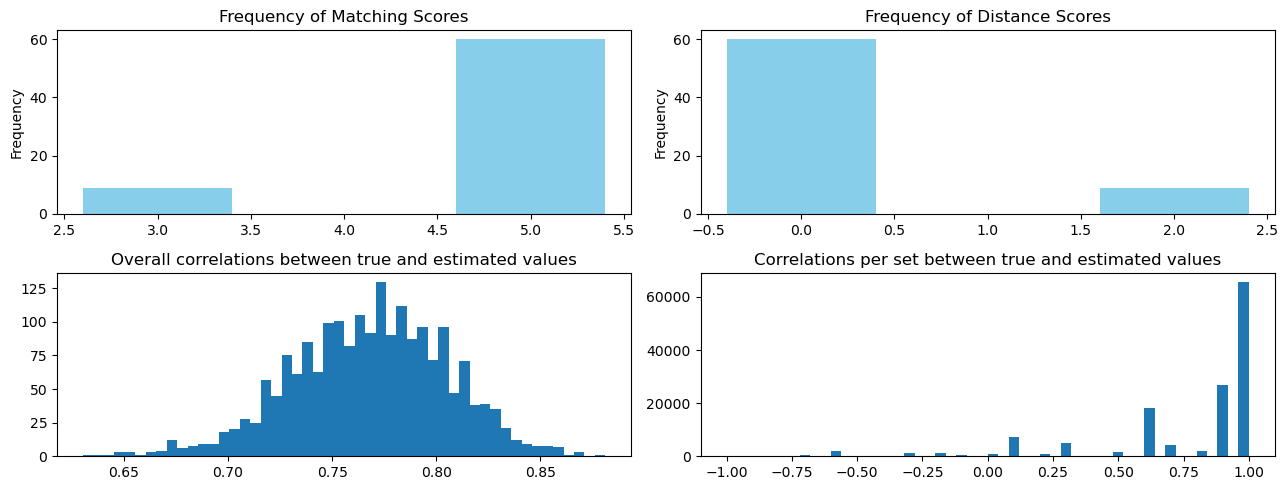

In [75]:
plot_results(trace7, ppc7)

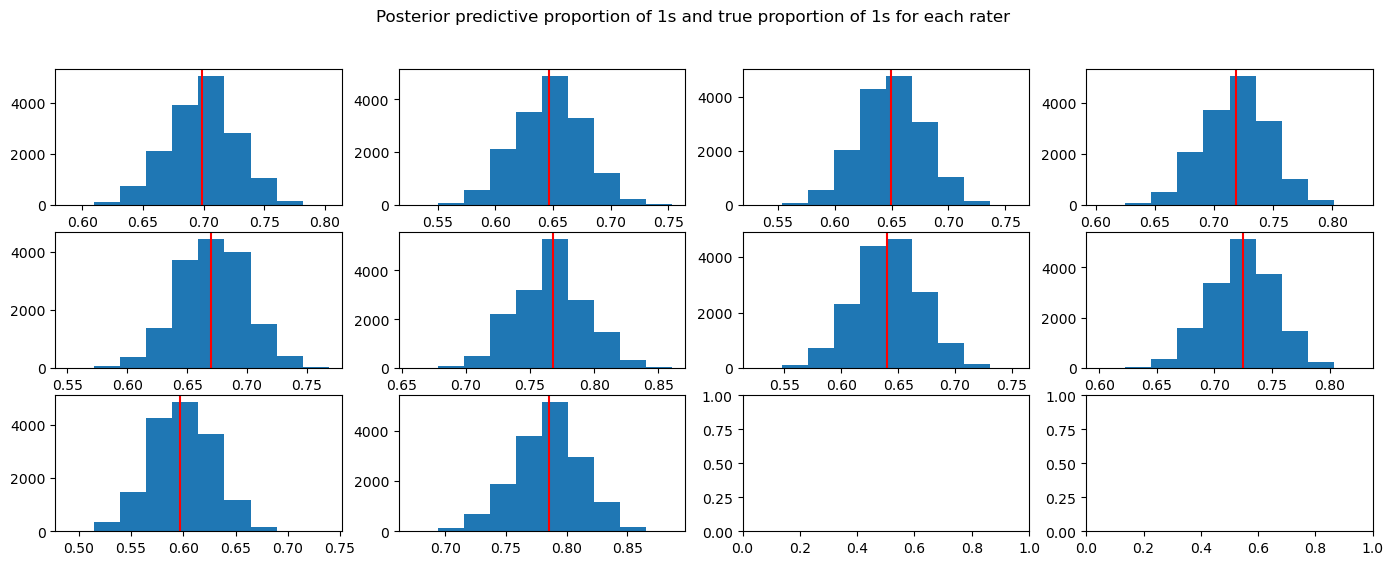

In [76]:
plot_binary_ppc(ppc7)

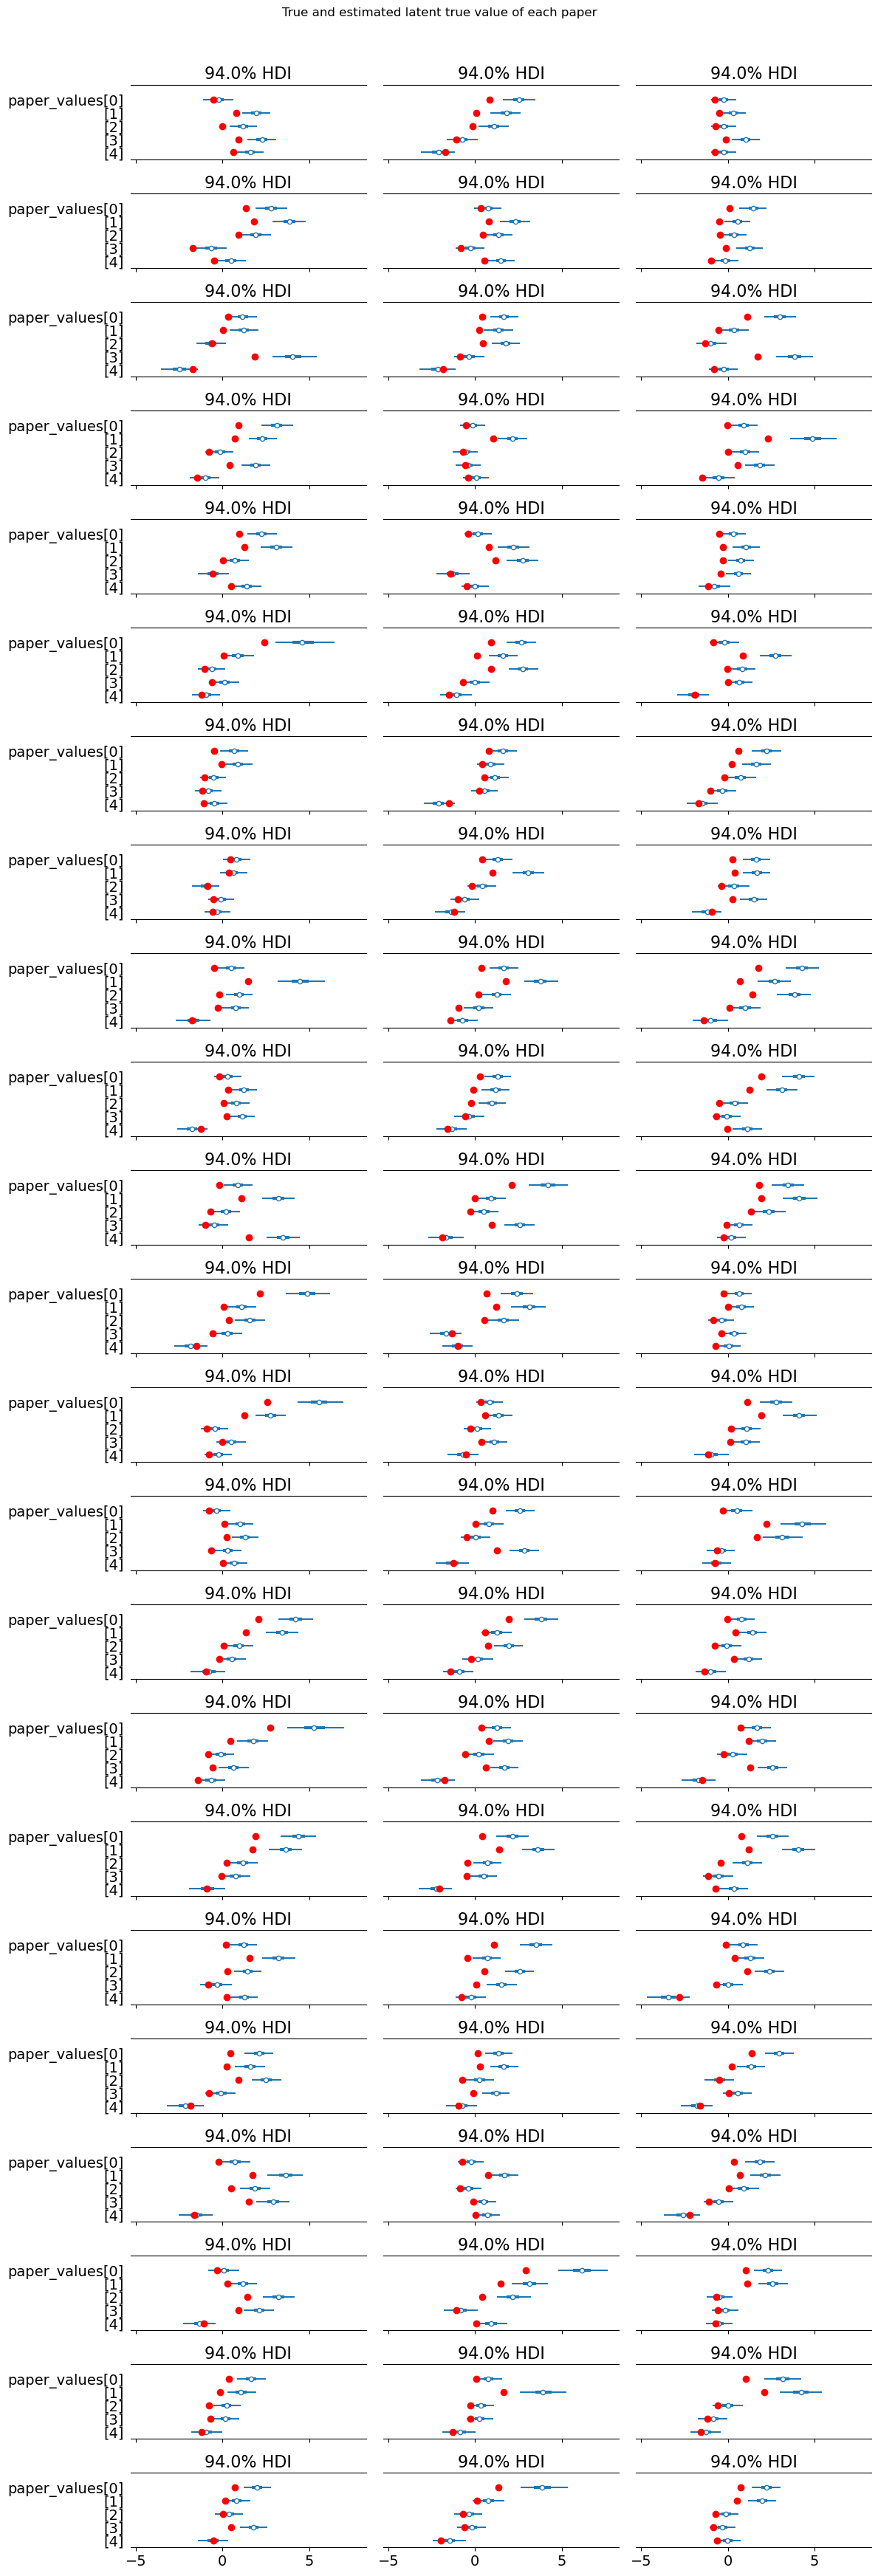

In [77]:
plot_paper_values(trace7, true_values, 'paper_values')

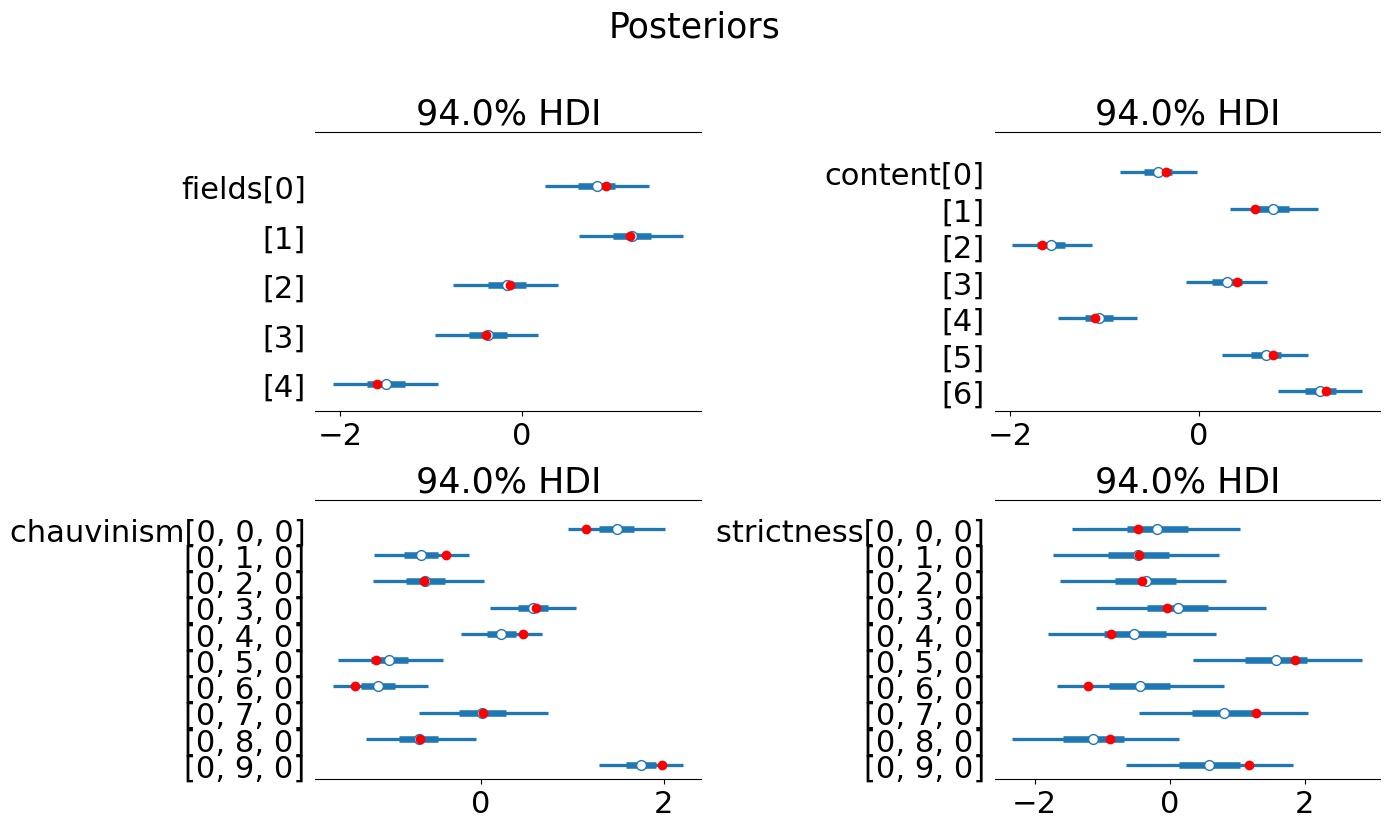

In [78]:
plot_posteriors(trace7, ['fields','content','chauvinism','strictness'])

<Axes: title={'center': 'sigma'}>

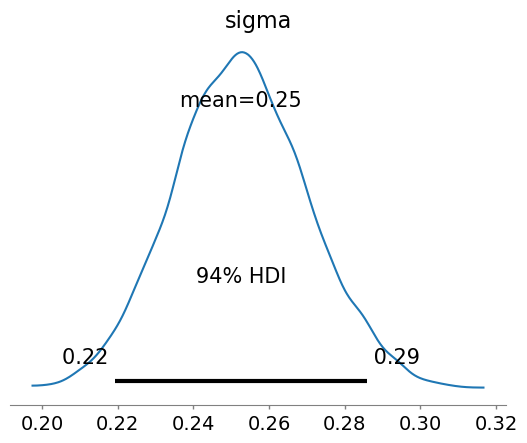

In [79]:
az.plot_posterior(trace7, var_names = 'sigma')

# Model8: Add hyperpriors for chauvinism and strictness

We have many raters with their own chauvinism and strictness. It would be good to pool this information, and let these estimates influence each other. So, we add hyperpriors for chauvinism and strictness to the model. This will shrink these estimates to the mean, making the model a bit more conservative, but also uses more of the information by pooling it.

In [80]:
with pm.Model() as model8:

    content = pm.Normal('content',0,1,shape = (len(content_params))) # priors for the content
    dot_prod = pt.dot(content_presence, content) # add in the inideces for the content
    dot_prod_reshaped = dot_prod.reshape((B,K)) # reshape to fit with the rest of the data

    fields = pm.Normal('fields',0, 1,shape = (K))
    
    paper_intercepts = pm.Normal('paper_intercepts',0,1, shape = (B,K))

    paper_values = pm.Deterministic('paper_values', paper_intercepts + fields[fields_presence]+ dot_prod_reshaped )

    # add hyperpriors to estimate the what the population of chauvinism looks like
    chauv_mean = pm.Normal('chauv_mean', 0, 1)
    chauv_sd = pm.Uniform('chauv_sd', 0.01, 2)

    # put these hyperpriors into the chauvinism prior
    chauvinism = pm.Normal('chauvinism',chauv_mean, chauv_sd, shape=(1,J,1))

    mu = pm.Deterministic('mu', pt.tile(paper_values[:,pt.newaxis,:],(1,J,1)) + (chauv_array * chauvinism))

    reordered_mu = pm.Deterministic('reordered_mu', pt.take_along_axis(mu, rank_data, axis = -1))

    sigma = pm.Uniform('sigma',0.01,2)
    
    latent = pm.Normal('latent',
                       mu=reordered_mu,
                       sigma=sigma, 
                       transform=Ordered(), 
                       shape=(B,J,K),
                       # have to set test value to avoid issues with negative numbers
                       testval=np.tile(np.tile(np.arange(K), (B, 1))[:, np.newaxis, :], (1, J, 1))) 

    latent_reshaped = pt.take_along_axis(latent, rank_data_argsort, axis = -1)

    # add hyperpriors for strictness
    strictness_mean = pm.Normal('strictness_mean',0,1)
    strictness_sd = pm.Uniform('strictness_sd', 0.01, 2)
    
    # put these hyperpriors into the strictness estimate
    strictness = pm.Normal('strictness',strictness_mean,strictness_sd,shape = (1,J,1))
    
    binary = pm.Bernoulli('binary',logit_p = latent_reshaped + strictness, observed = binary_data)
    pr8 = pm.sample_prior_predictive()

Sampling: [binary, chauv_mean, chauv_sd, chauvinism, content, fields, latent, paper_intercepts, sigma, strictness, strictness_mean, strictness_sd]


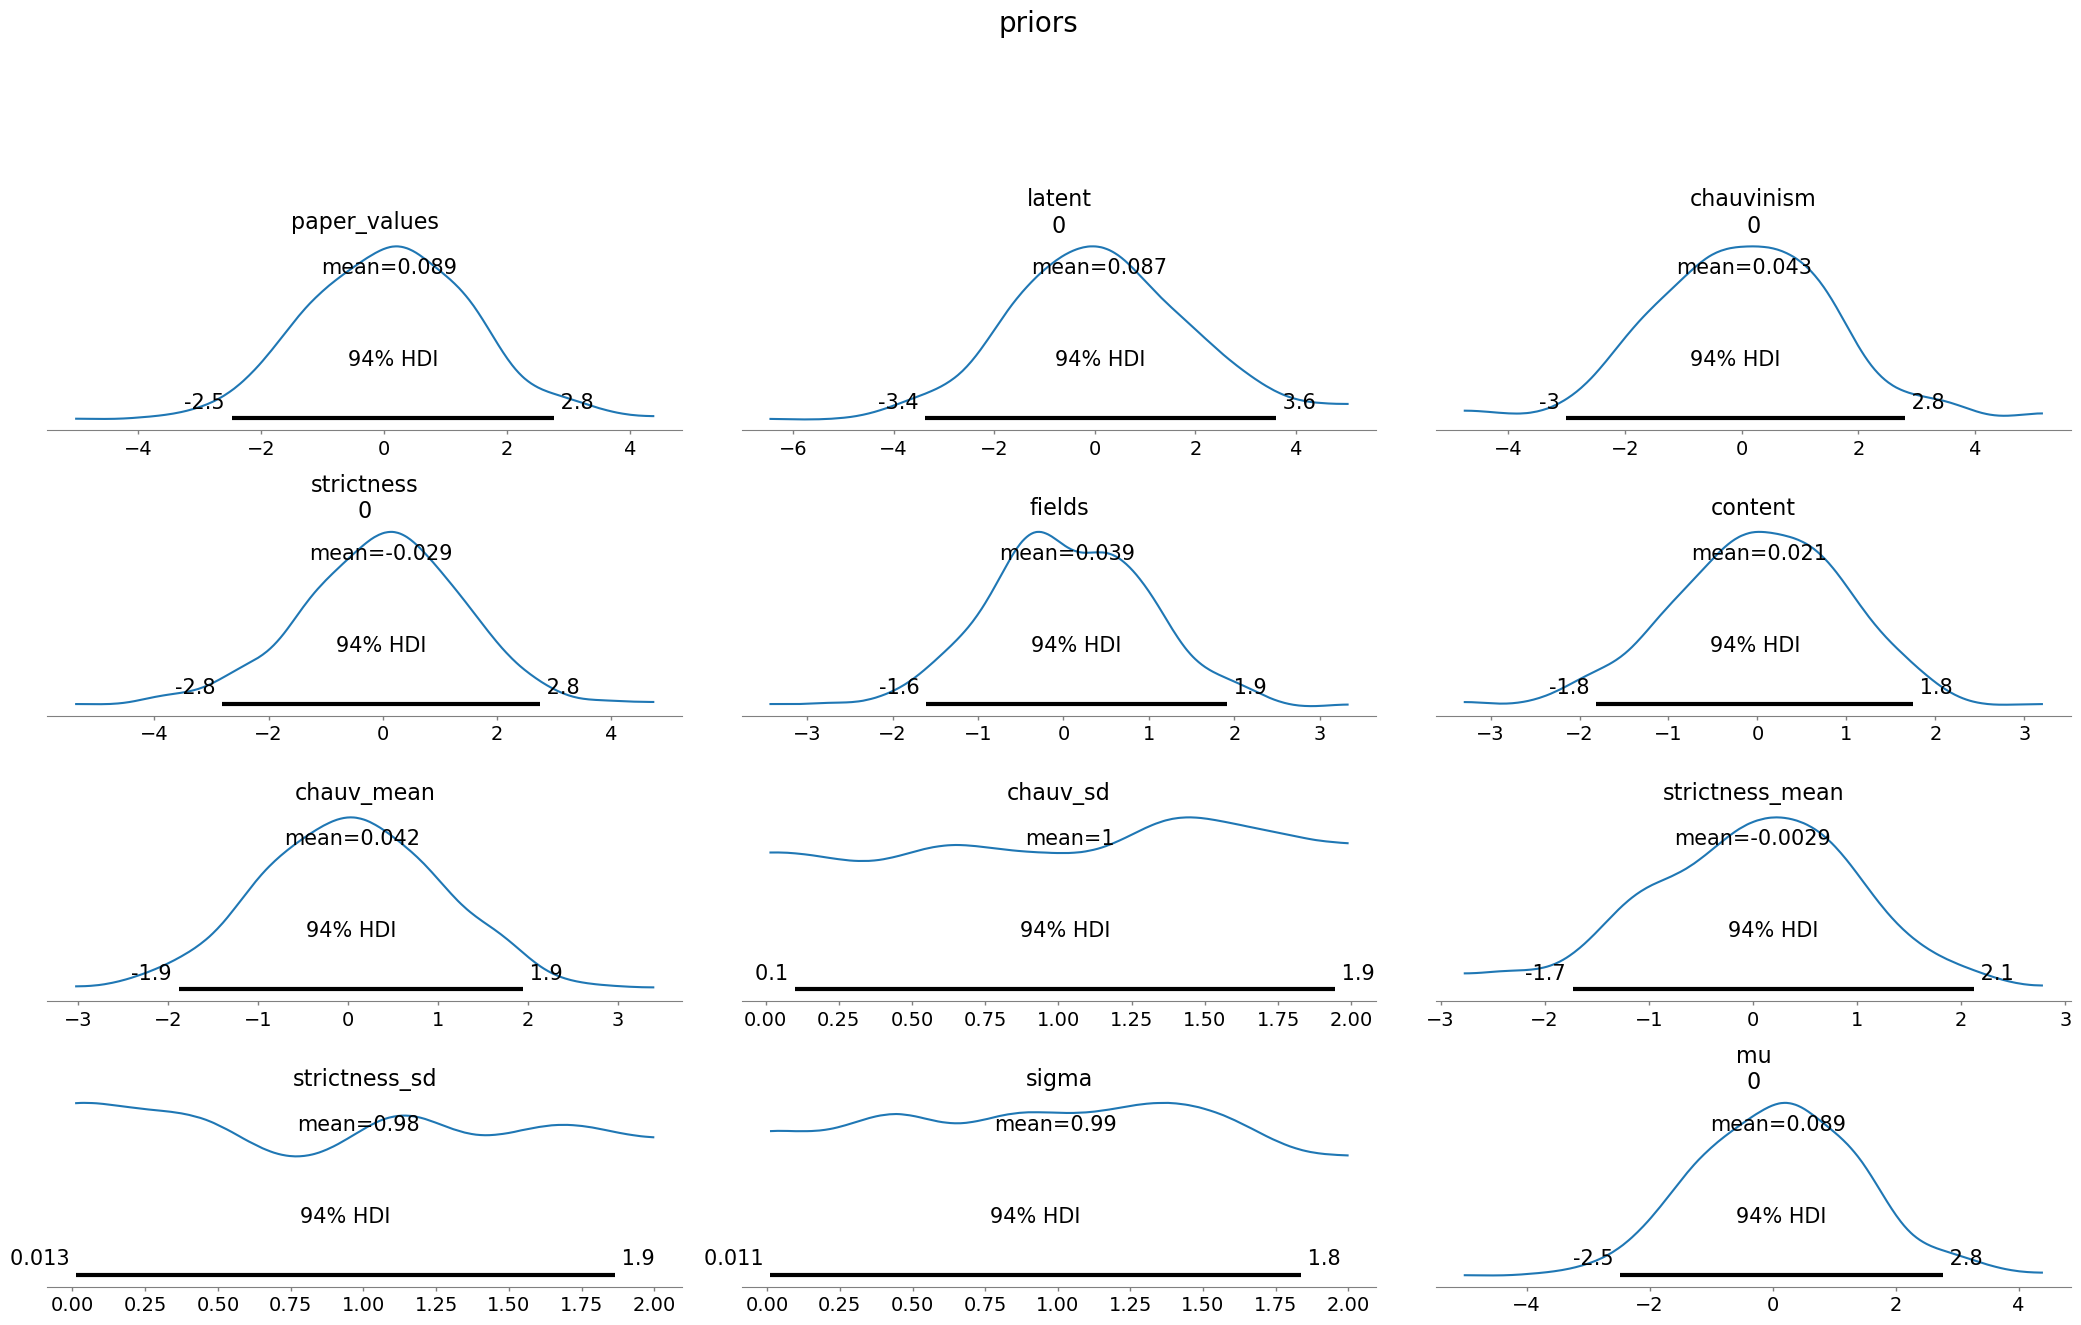

In [81]:
plot_priors(pr8, ['paper_values','latent','chauvinism','strictness','fields','content','chauv_mean','chauv_sd','strictness_mean','strictness_sd','sigma','mu'])

In [82]:
with model8:
    trace8 = pm.sample(5000,idata_kwargs={"log_likelihood": True},target_accept = 0.80)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [content, fields, paper_intercepts, chauv_mean, chauv_sd, chauvinism, sigma, latent, strictness_mean, strictness_sd, strictness]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 6651 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [83]:
trace8.to_netcdf("...\SimulTrace8.nc")

'C:\\Users\\conix\\Documents\\IIH_localtraces\\SimulTrace8.nc'

In [84]:
trace8 = az.from_netcdf("...\SimulTrace8.nc")

In [85]:
with model8:
    ppc8 = pm.sample_posterior_predictive(trace8, var_names = ['paper_values','binary'])

Sampling: [binary, latent]


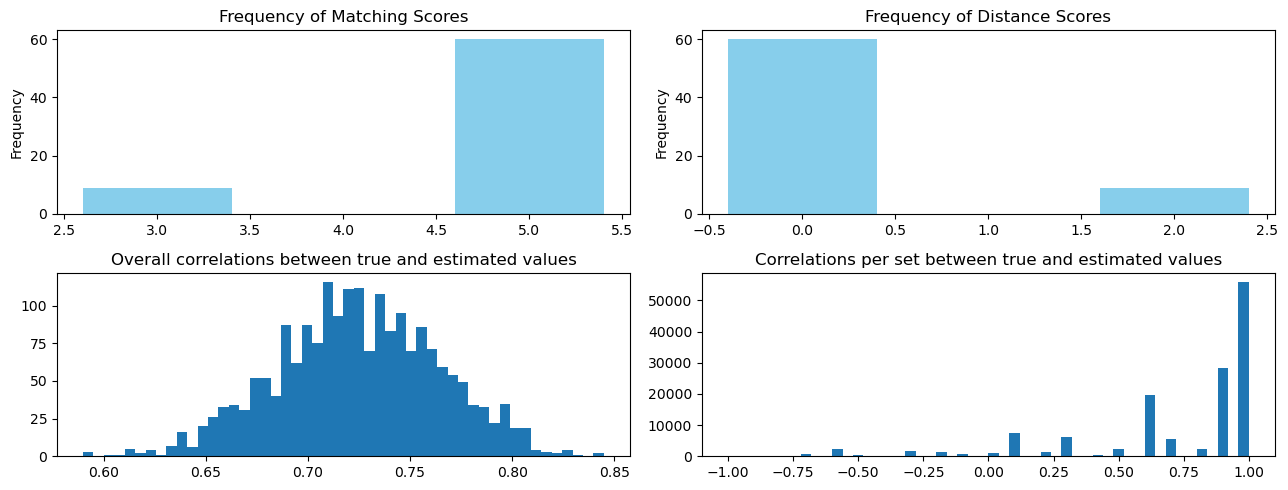

In [86]:
plot_results(trace8, ppc8)

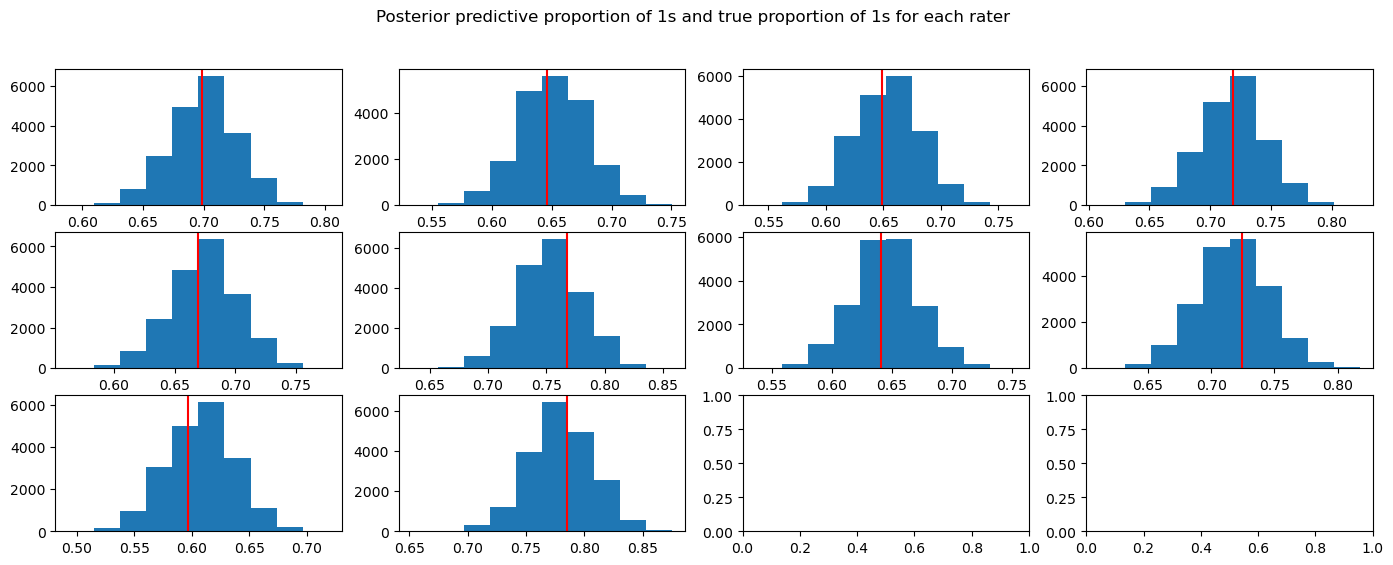

In [87]:
plot_binary_ppc(ppc8)

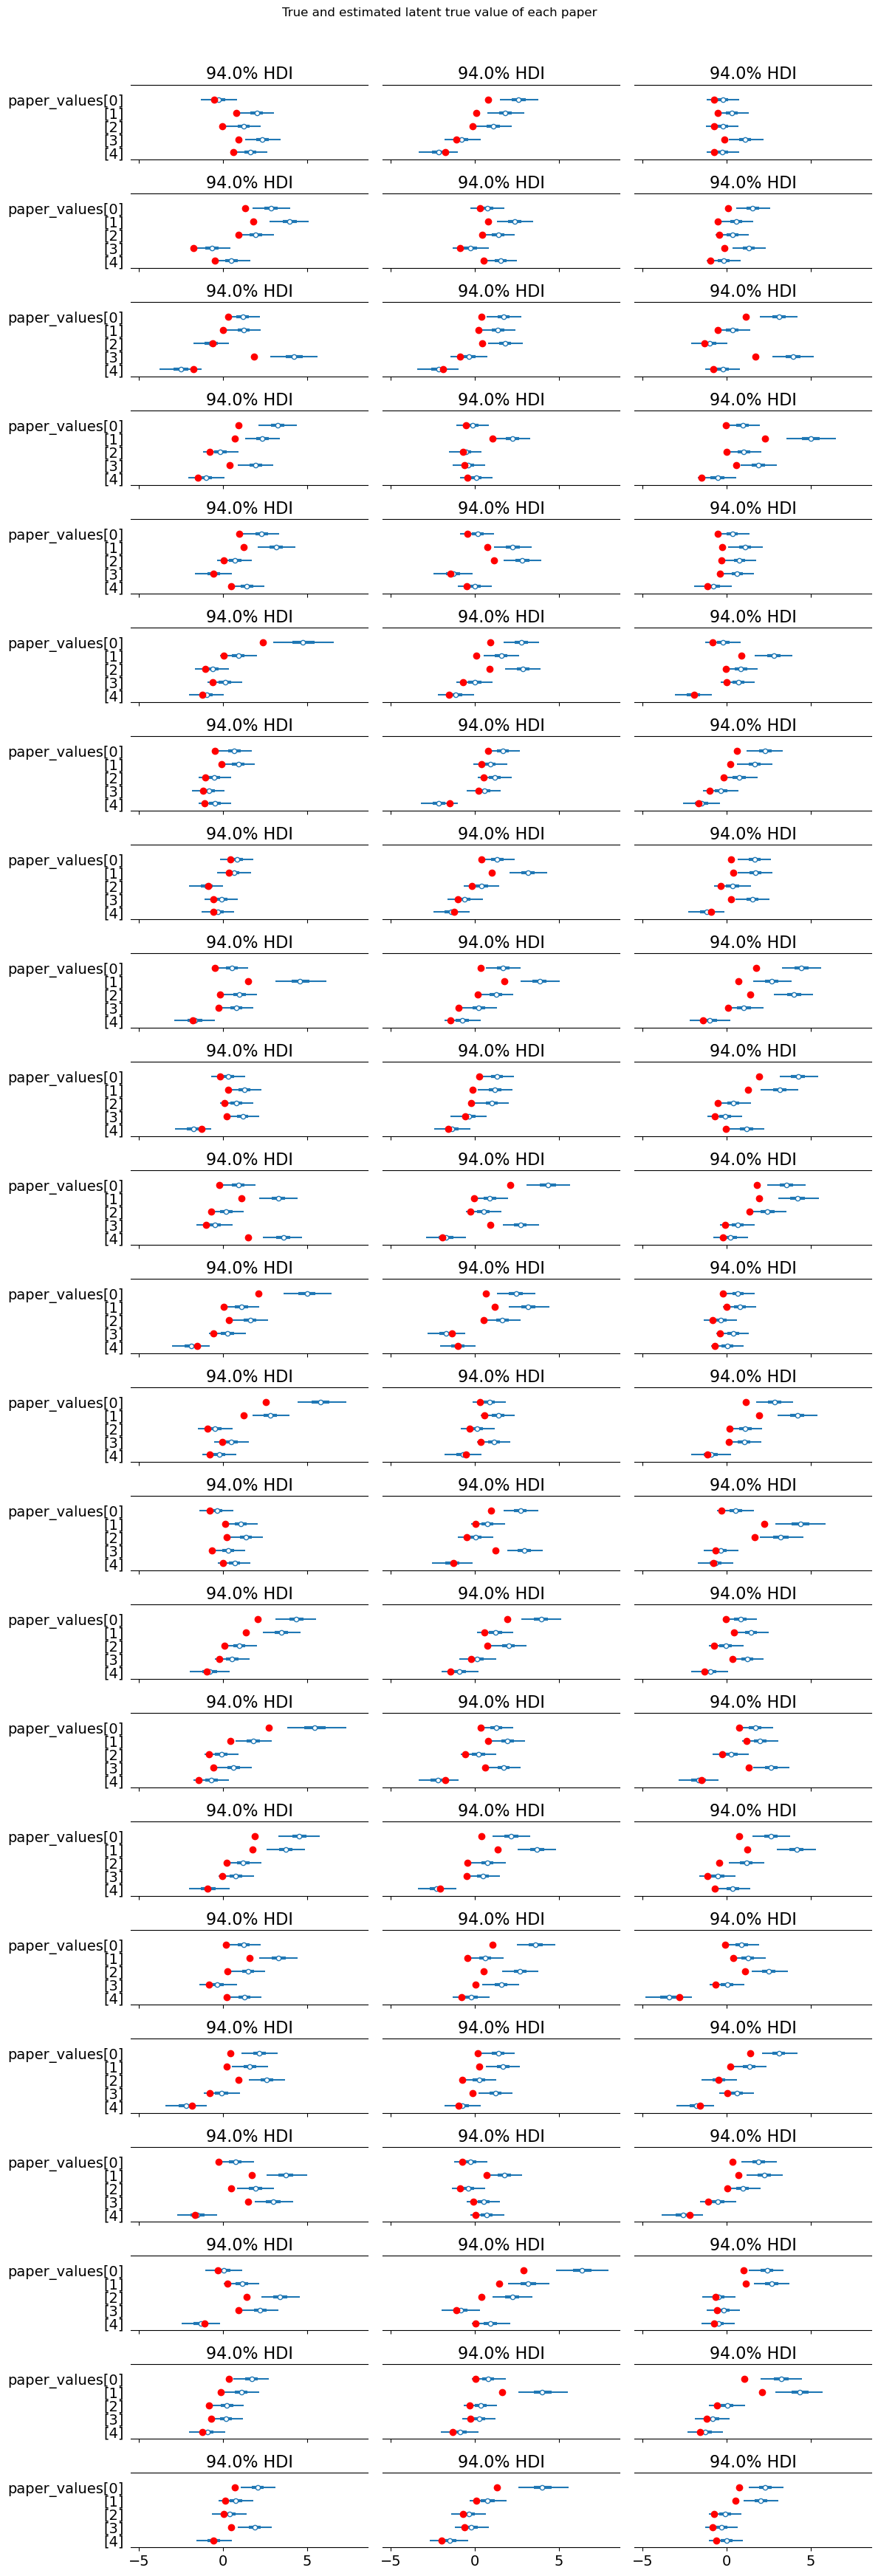

In [88]:
plot_paper_values(trace8, true_values, 'paper_values')


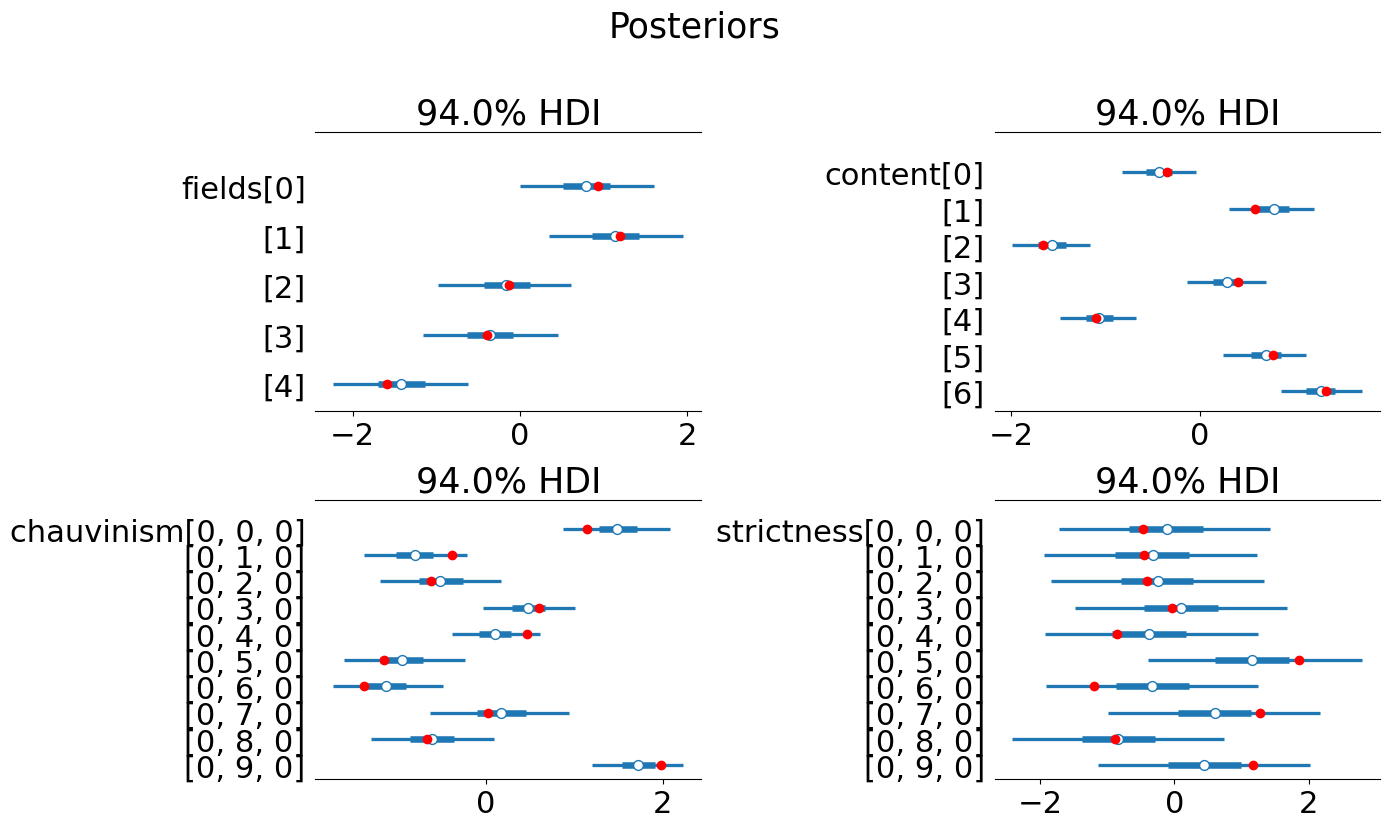

In [89]:
plot_posteriors(trace8, ['fields','content','chauvinism','strictness'])

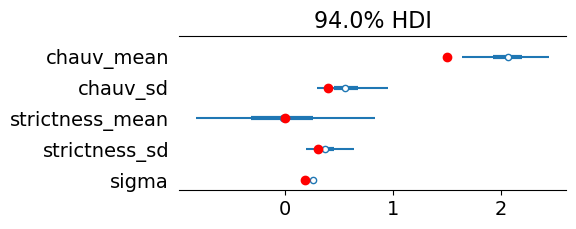

In [90]:
fig, ax = plt.subplots(figsize = (5,2))

var_names = ['chauv_mean','chauv_sd','strictness_mean','strictness_sd','sigma']
az.plot_forest(trace8, var_names = var_names,combined = True, ax=ax)
y_locs = ax.yaxis.get_majorticklocs()[::-1]
true = [true_values[i] for i in var_names]
ax.scatter(true, y_locs, c='r', zorder=5)
plt.show()



# Model 9: Use non-centered parametrization for chauvinism and strictness

In hierarchical models, which use hyperpriors like we do here for strictness and chauvinism, sampling is often easier if you use a non-centered parametrization. (See [here](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/multilevel_modeling.html) for more on this.) We don't do this for fields because it doesn't really make conceptual sense to think that those parameters have been sampled from a distribution of field values, and there are only 5 fields (making it hard to estimate the distribution). We also don't do this for the content parameters because there is no reason to think these come from some kind of a distribution; rather, they are probably entirely unrelated.

In [91]:
with pm.Model() as model9:

    # data
    CONTENT = pm.MutableData('CONTENT', content_presence)
    
    content = pm.Normal('content',0,1,shape = (len(content_params)))
    dot_prod = pt.dot(content_presence, content)
    dot_prod_reshaped = dot_prod.reshape((B,K))

    fields_mean = pm.Normal('fields_mean', 0, 1)
    fields_sd = pm.Uniform('fields_sd', 0.01, 2)
    
    fields = pm.Normal('fields',0, fields_sd,shape = (K))

    paper_intercepts = pm.Normal('paper_intercepts',0,1, shape = (B,K))
    paper_values = pm.Deterministic('paper_values', paper_intercepts + fields[fields_presence]+ dot_prod_reshaped )

    chauv_mean = pm.Normal('chauv_mean', 0, 1)
    chauv_sd = pm.Uniform('chauv_sd', 0.01, 2)
    
    # Non-centered parameterization for chauvinism
    chauvinism_offset = pm.Normal('chauvinism_offset', 0, 1, shape=(1, J, 1))
    chauvinism = pm.Deterministic('chauvinism', chauv_mean + chauv_sd * chauvinism_offset)

    mu = pm.Deterministic('mu', pt.tile(paper_values[:,pt.newaxis,:],(1,J,1)) + (chauv_array * chauvinism))

    reordered_mu = pm.Deterministic('reordered_mu', pt.take_along_axis(mu, rank_data, axis = -1))
    
    sigma = pm.Uniform('sigma',0.01,2)
    
    latent = pm.Normal('latent',
                       mu=reordered_mu,
                       sigma=sigma, 
                       transform=Ordered(), 
                       shape=(B,J,K),
                       # have to set test value to avoid issues with negative numbers
                       testval=np.tile(np.tile(np.arange(K), (B, 1))[:, np.newaxis, :], (1, J, 1))) 

    latent_reshaped = pt.take_along_axis(latent, rank_data_argsort, axis = -1)


    strictness_mean = pm.Normal('strictness_mean',0,1)
    strictness_sd = pm.Uniform('strictness_sd', 0.01, 2)
    
    # Non-centered parameterization for strictness
    strictness_offset = pm.Normal('strictness_offset', 0, 1, shape=(1, J, 1))
    strictness = pm.Deterministic('strictness', strictness_mean + strictness_sd * strictness_offset)

    binary = pm.Bernoulli('binary',logit_p = latent_reshaped + strictness, observed = binary_data)
    pr9 = pm.sample_prior_predictive()

Sampling: [binary, chauv_mean, chauv_sd, chauvinism_offset, content, fields, fields_mean, fields_sd, latent, paper_intercepts, sigma, strictness_mean, strictness_offset, strictness_sd]


In [92]:
with model9:
    trace9 = pm.sample(7000, tune = 1500, idata_kwargs={"log_likelihood": True},target_accept = 0.8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [content, fields_mean, fields_sd, fields, paper_intercepts, chauv_mean, chauv_sd, chauvinism_offset, sigma, latent, strictness_mean, strictness_sd, strictness_offset]


Sampling 4 chains for 1_500 tune and 7_000 draw iterations (6_000 + 28_000 draws total) took 11075 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [93]:
trace9.to_netcdf("...\SimulTrace9.nc")

'C:\\Users\\conix\\Documents\\IIH_localtraces\\SimulTrace9.nc'

In [94]:
trace9 = az.from_netcdf("...\SimulTrace9.nc")

In [96]:
with model9:
    ppc9 = pm.sample_posterior_predictive(trace9, var_names = ['paper_values','binary','latent'])

Sampling: [binary, latent]


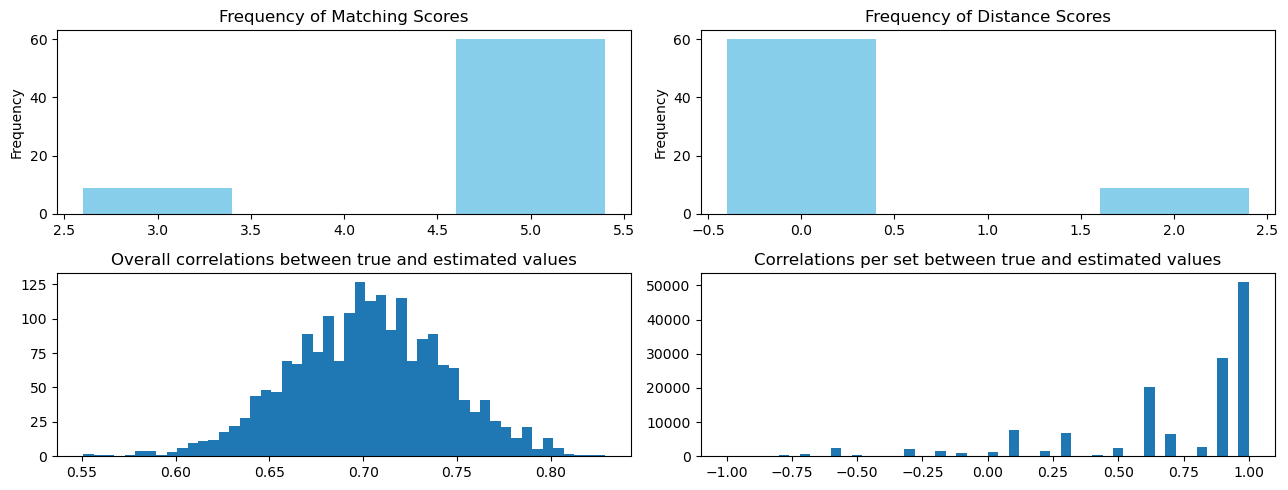

In [97]:
plot_results(trace9, ppc9)

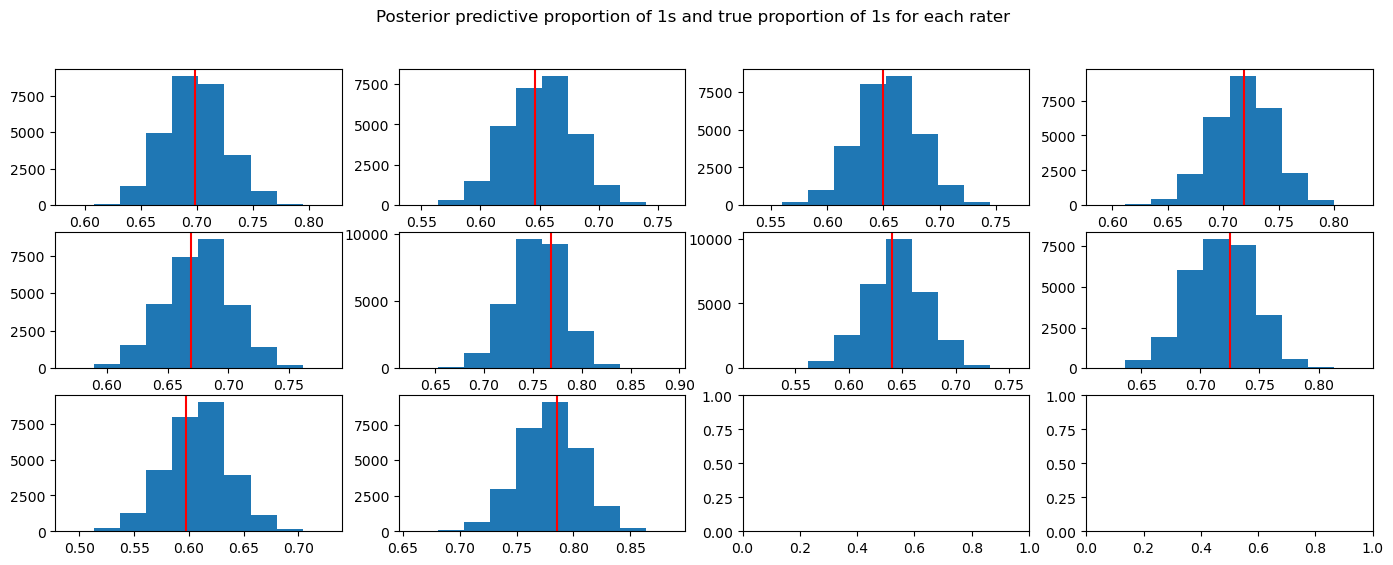

In [98]:
plot_binary_ppc(ppc9)

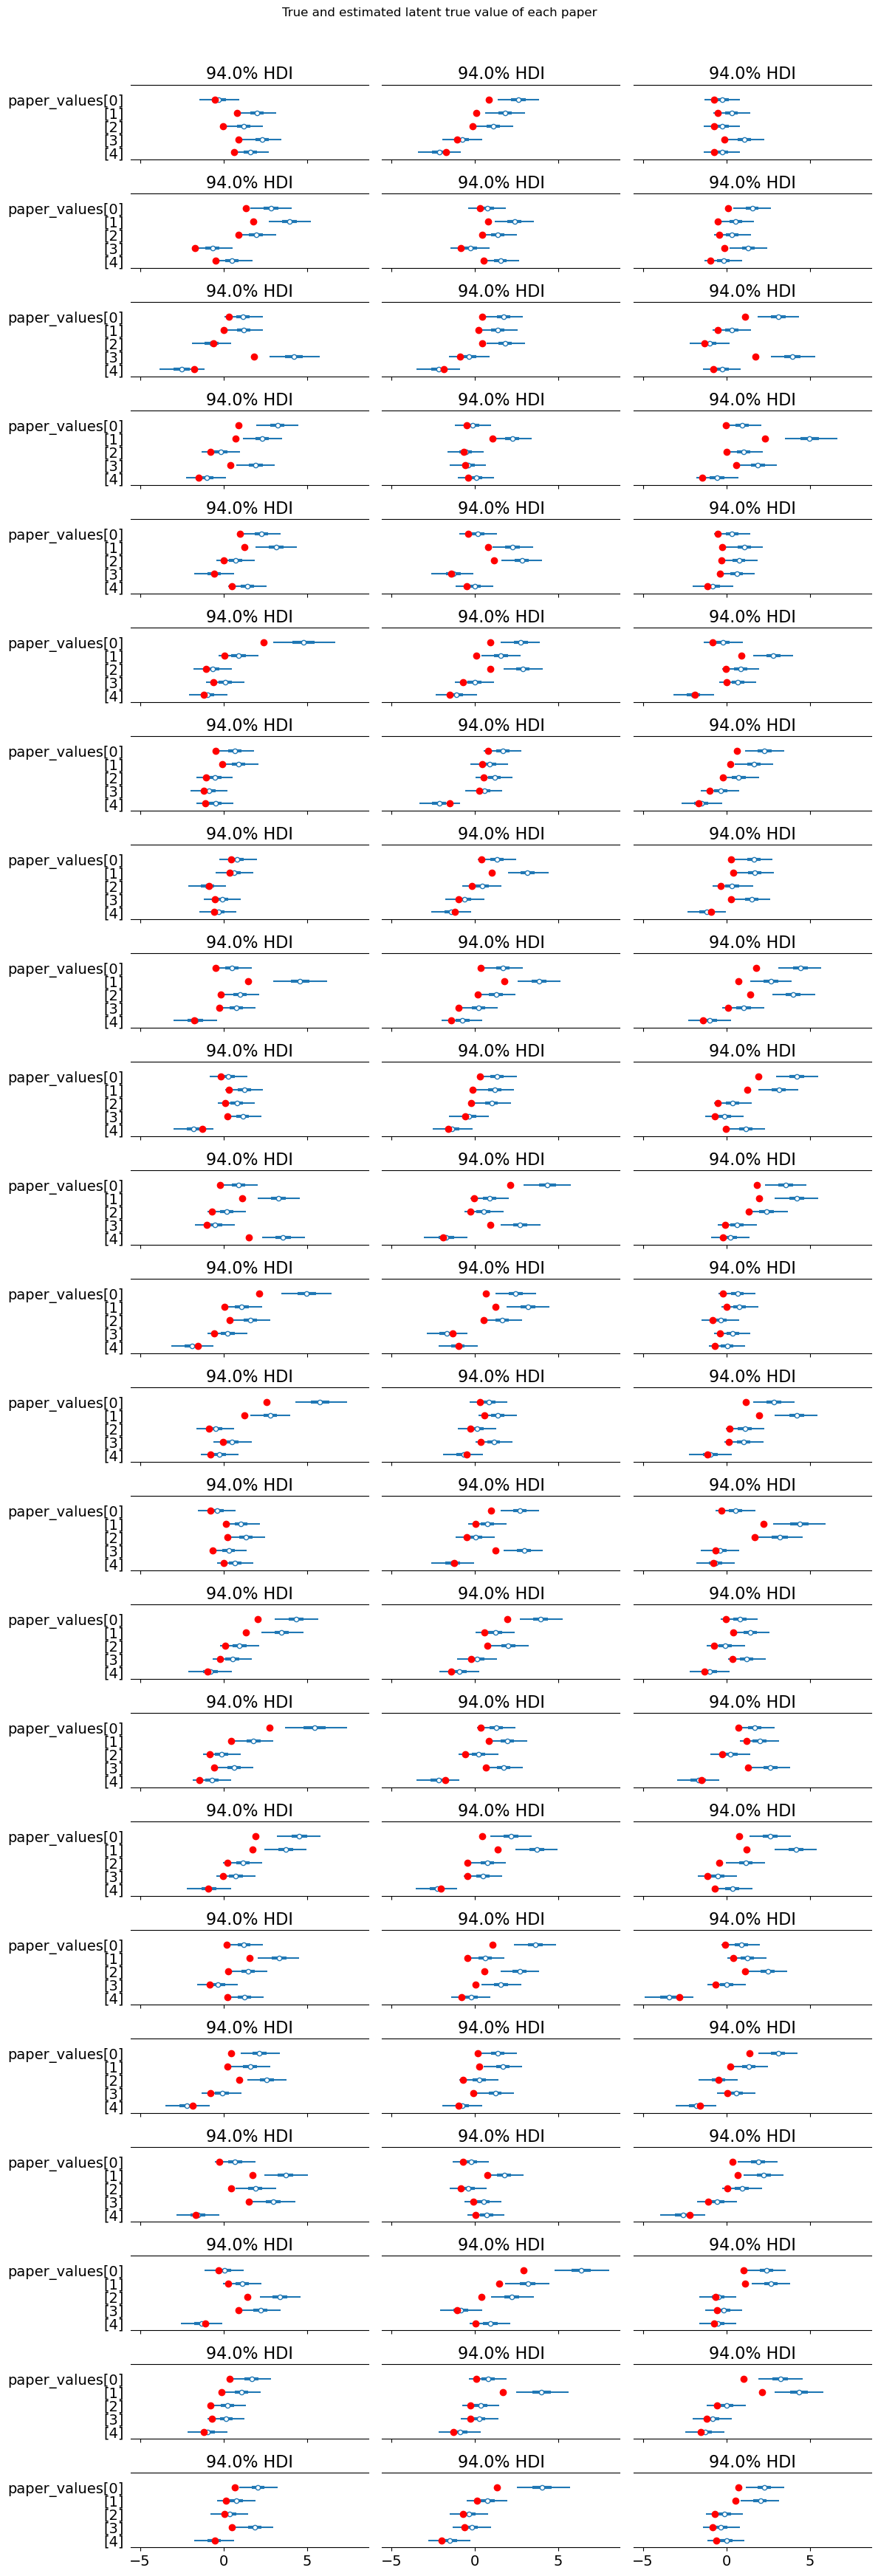

In [99]:
plot_paper_values(trace9, true_values, 'paper_values')


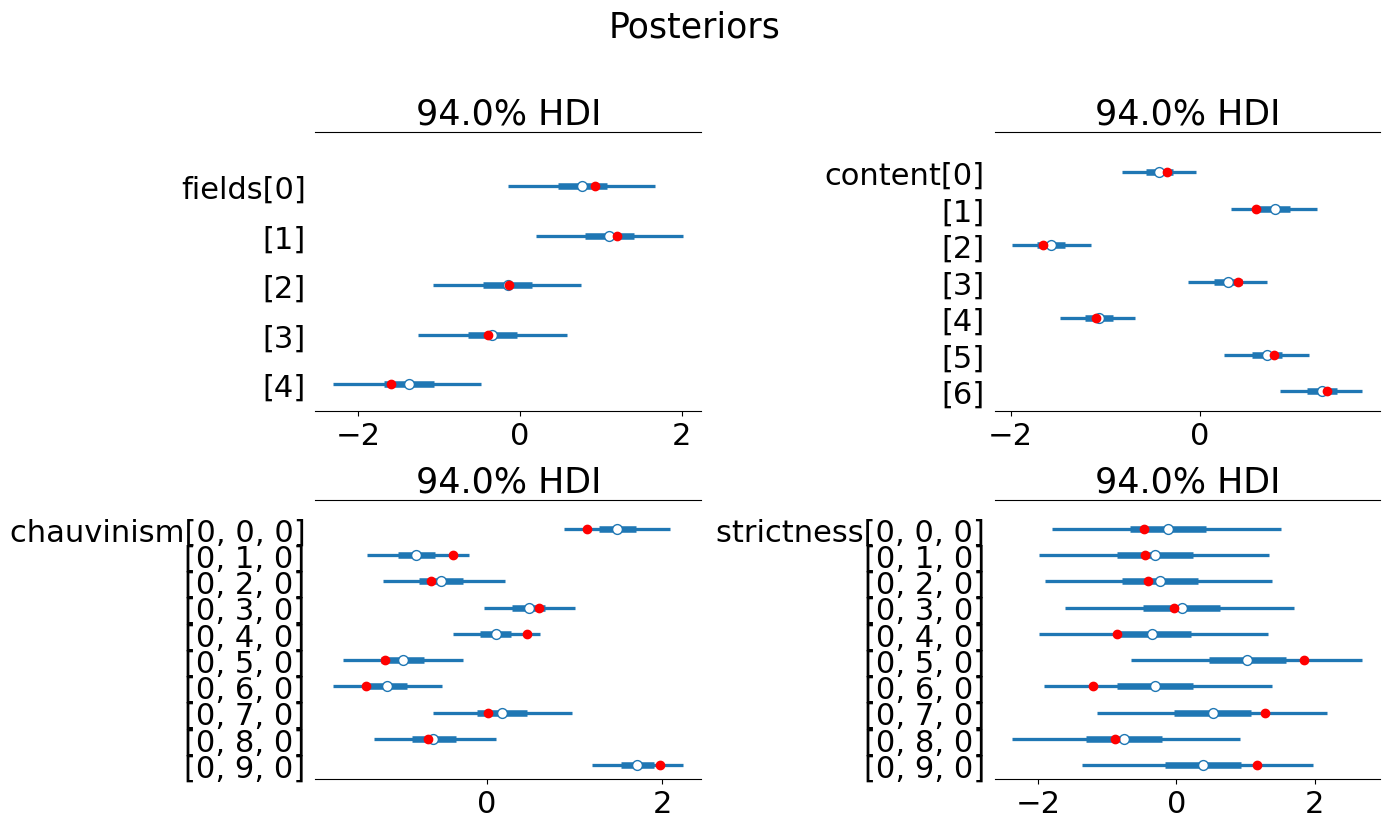

In [100]:
plot_posteriors(trace9,['fields','content','chauvinism','strictness'])

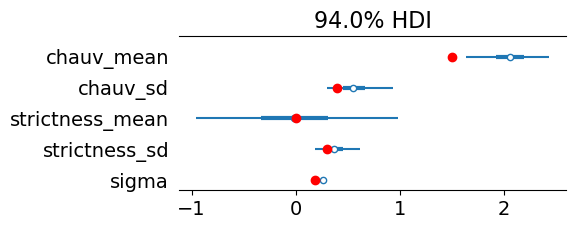

In [101]:
fig, ax = plt.subplots(figsize = (5,2))

var_names = ['chauv_mean','chauv_sd','strictness_mean','strictness_sd','sigma']
az.plot_forest(trace9, var_names = var_names,combined = True, ax=ax)
y_locs = ax.yaxis.get_majorticklocs()[::-1]
true = [true_values[i] for i in var_names]
ax.scatter(true, y_locs, c='r', zorder=5)
plt.show()


# Compare models

In [102]:
traces = {"thurston": trace1, "AddFields": trace3, 'AddContent':trace4,'AddStrictness':trace5, 'AddChauv':trace6,'AddSigma':trace7, 'AddHypers':trace8, 'noncentered': trace9}

models = {model1: trace1,  model3: trace3, model4:trace4,model5:trace5, model6:trace6, model7:trace7,model8:trace8,  model9:trace9, }

ppcs = {"thurston": ppc1, "AddFields": ppc3, 'AddContent':ppc4,'AddStrictness':ppc5, 'AddChauv':ppc6,'AddSigma':ppc7, 'AddHypers':ppc8, 'non-centered':ppc9}


## cross validation

Note: only the binary outcome is defined as a likelihood in the model. Hence, all this crossvalidation is only for what is arguably the less interesting observed variable. Because we put the ranking data into the model through indexing (and not really as an Observed in the normal distribution), pymc doesn't recognise latent as one of the likelihoods and there is no way of automatically calculating loo. Perhaps look into doing it manually.

In [103]:
df_comp_loo = az.compare(traces, var_name='binary', ic = 'loo')
df_comp_loo

C:\Users\conix\.conda\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1040: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


rank     elpd_loo       p_loo   elpd_diff        weight  \
AddSigma          0 -1643.622270  100.854857    0.000000  8.632759e-01   
noncentered       1 -1646.551452  102.330497    2.929182  1.351719e-13   
AddHypers         2 -1646.663982  102.314787    3.041712  4.822402e-14   
AddStrictness     3 -1670.495649  271.465915   26.873379  3.286206e-12   
AddContent        4 -1692.215726  267.996987   48.593456  4.316675e-12   
AddFields         5 -1697.433310  260.219693   53.811040  1.899282e-02   
thurston          6 -1752.029648  252.024720  108.407378  1.177313e-01   
AddChauv          7 -1764.138425  351.271504  120.516155  0.000000e+00   

                      se        dse  warning scale  
AddSigma       35.297747   0.000000    False   log  
noncentered    35.897908   1.439368    False   log  
AddHypers      35.900693   1.428634    False   log  
AddStrictness  34.484506   9.489202    False   log  
AddContent     34.064219  12.352658    False   log  
AddFields      32.301098  13.296195    False   log  
thurston       27.505832  17.070675    False   log  
AddChauv       47.839154  15.293737    False   log

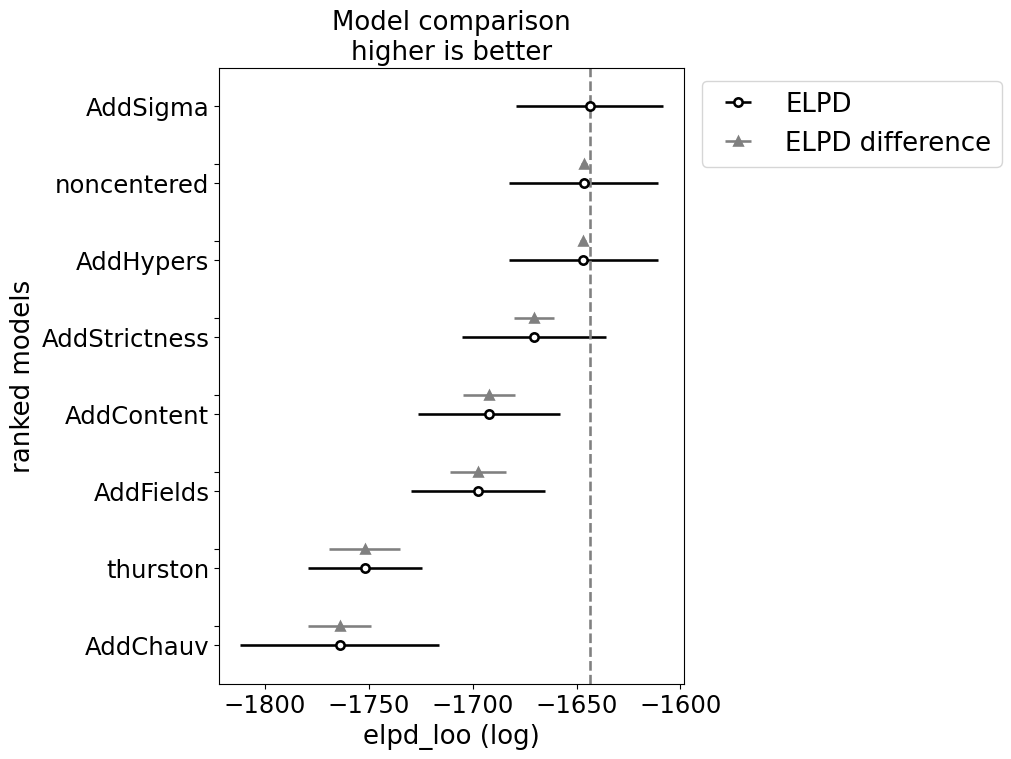

In [104]:
az.plot_compare(df_comp_loo, insample_dev=False);

C:\Users\conix\.conda\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1040: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


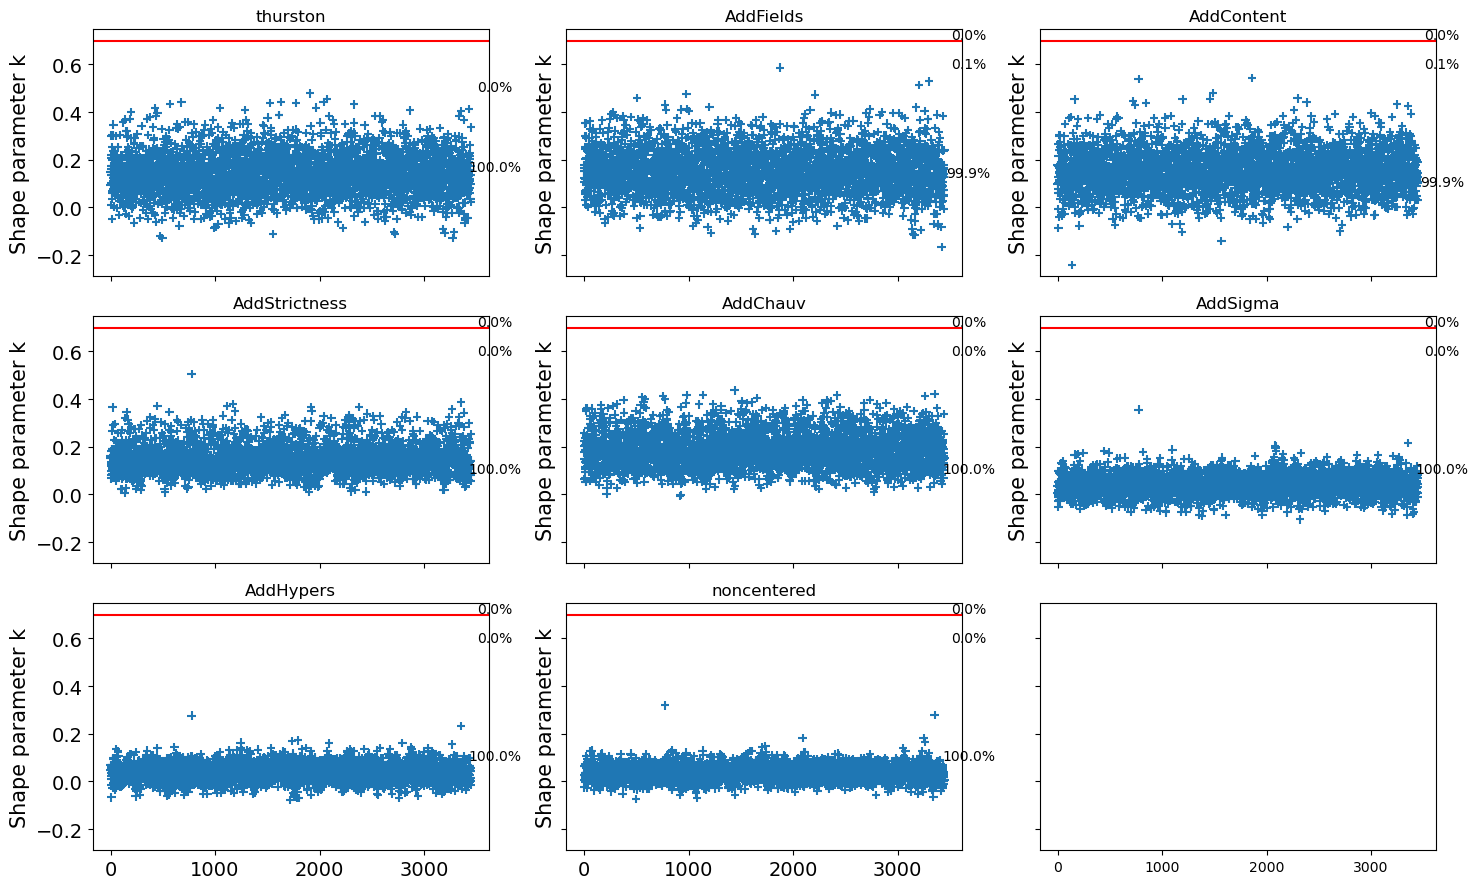

In [105]:
# check the k hat to see if there are very influential observations.

grid = calculate_subplot_grid(len(traces))

fig, axs = plt.subplots(ncols = grid[0],nrows = grid[1], figsize = (15,grid[1]*3), sharey=True, sharex=True)

for ax, i in zip(axs.flat, range(len(traces))):
    loo = az.loo(list(traces.values())[i], pointwise=True, var_name = 'binary')
    az.plot_khat(loo, show_bins=True, ax=ax)
    ax.set_title(list(traces.keys())[i])
    ax.set_xlabel('')
    ax.axhline(0.7, color = 'r')
fig.tight_layout()

## Compare parameter estimates

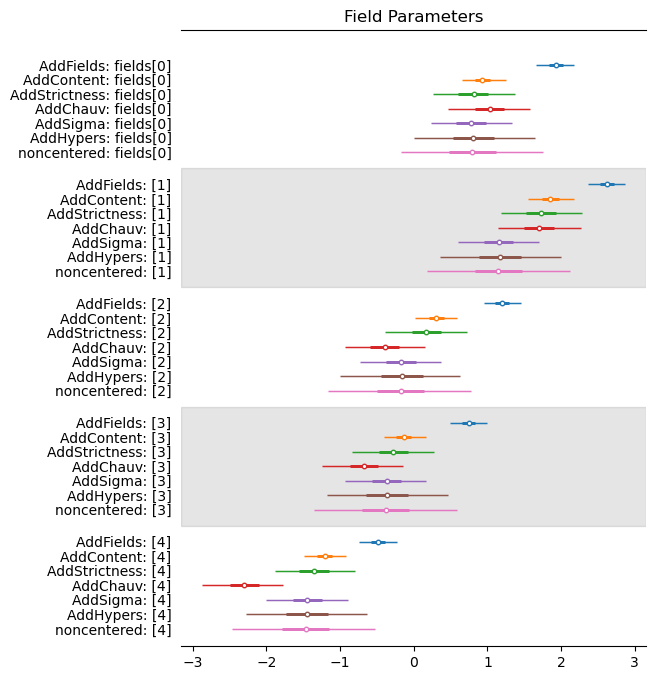

In [106]:
fig, ax = plt.subplots(figsize = (6,8))

az.plot_forest(list(traces.values())[1:], model_names = list(traces.keys())[1:], var_names = 'fields', combined = True, textsize = 10,legend = False, ax=ax)

ax.set_title('Field Parameters')
plt.show()

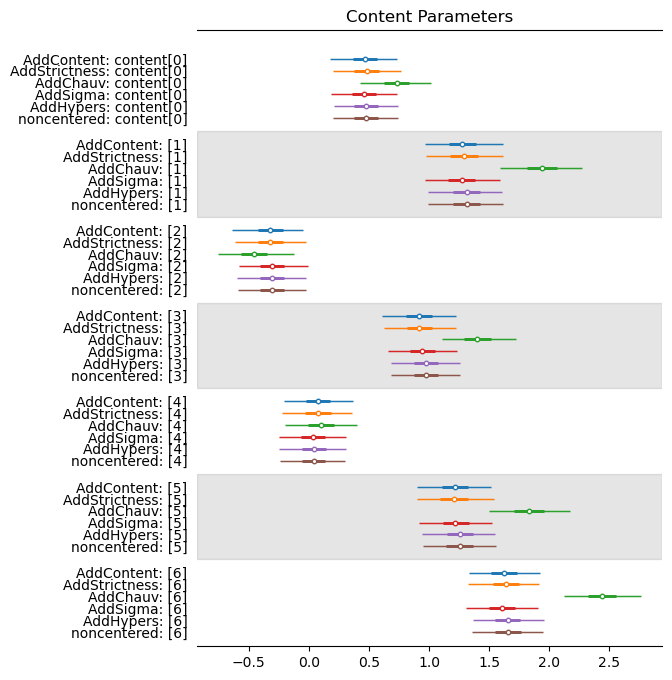

In [107]:
fig, ax = plt.subplots(figsize = (6,8))

az.plot_forest(list(traces.values())[2:], model_names = list(traces.keys())[2:], var_names = 'content', combined = True, textsize = 10,legend = False, ax=ax)

ax.set_title('Content Parameters')
plt.show()

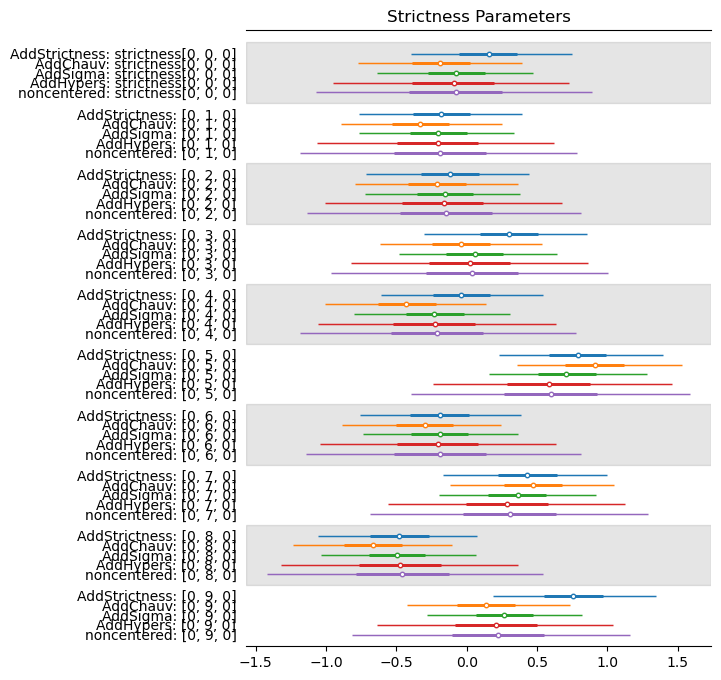

In [108]:
fig, ax = plt.subplots(figsize = (6,8))

az.plot_forest(list(traces.values())[3:], model_names = list(traces.keys())[3:], var_names = 'strictness', combined = True, textsize = 10,legend = False, ax=ax)

ax.set_title('Strictness Parameters')
plt.show()

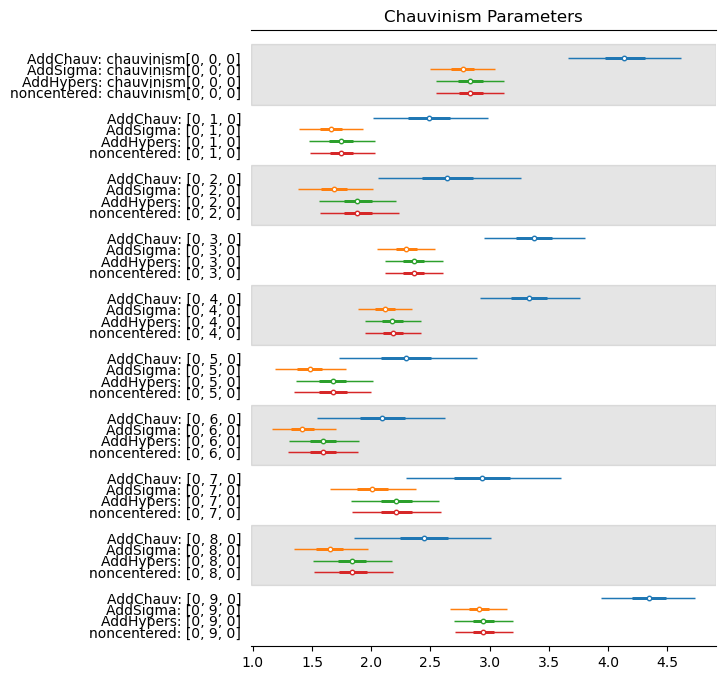

In [109]:
fig, ax = plt.subplots(figsize = (6,8))

az.plot_forest(list(traces.values())[4:], model_names = list(traces.keys())[4:], var_names = 'chauvinism', combined = True, textsize = 10,legend = False, ax=ax)

ax.set_title('Chauvinism Parameters')
plt.show()

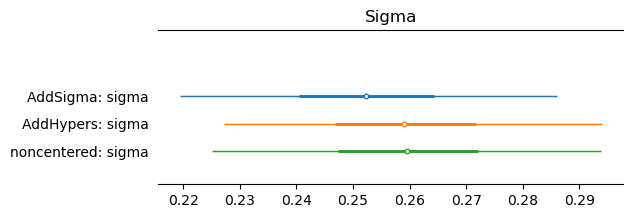

In [115]:
fig, ax = plt.subplots(figsize = (6,2))

az.plot_forest(list(traces.values())[5:], model_names = list(traces.keys())[5:], var_names = 'sigma', combined = True, textsize = 10,legend = False, ax=ax)

ax.set_title('Sigma')
plt.show()

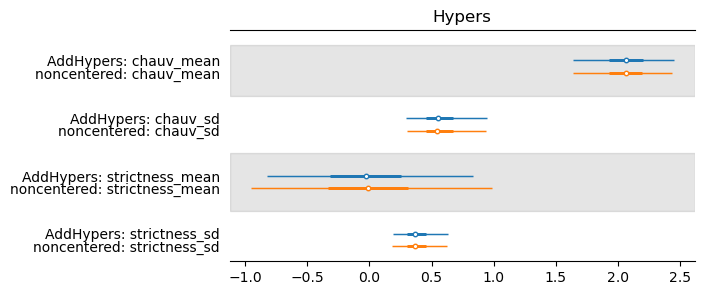

In [116]:
fig, ax = plt.subplots(figsize = (6,3))

az.plot_forest(list(traces.values())[6:], model_names = list(traces.keys())[6:], var_names = ['chauv_mean','chauv_sd','strictness_mean','strictness_sd'], combined = True, textsize = 10,legend = False, ax=ax)

ax.set_title('Hypers')
plt.show()

## Correlations

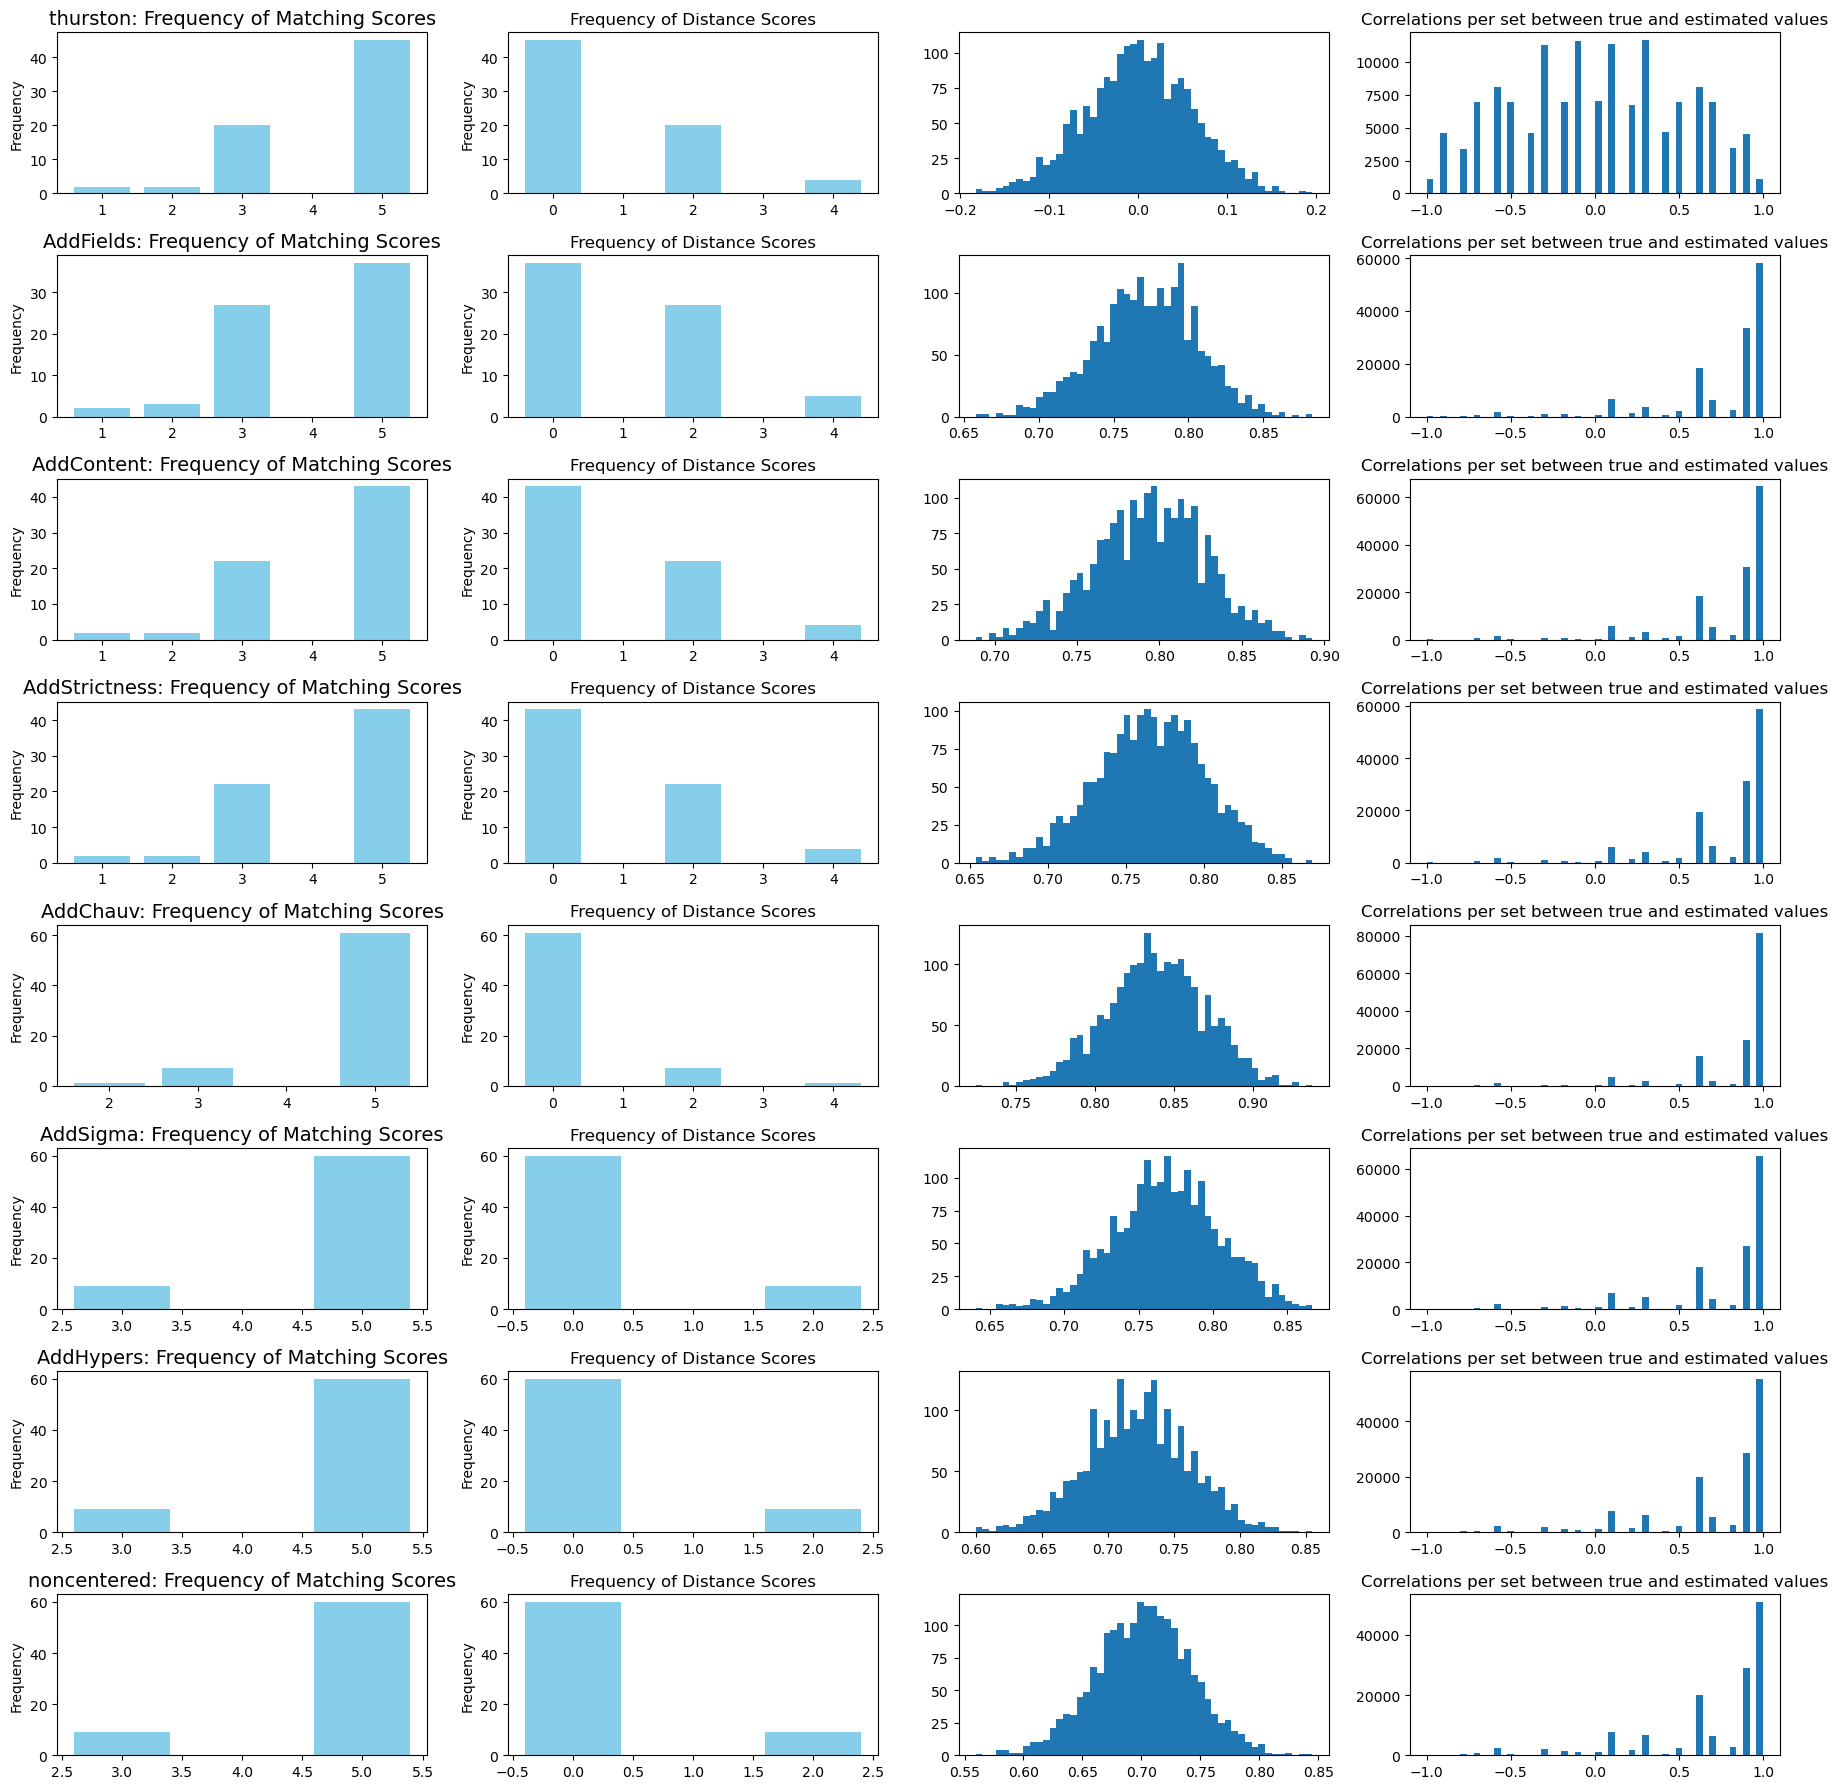

In [122]:
fig, ax = plt.subplots(ncols = 4, nrows = len(traces), figsize = (18,18))

for i in range(len(traces)):
    
    sets, overalls = get_corrs(list(ppcs.values())[i], real_paper_ranks)
    estimated_ranks = np.argsort(list(traces.values())[i].posterior['paper_values'].mean(dim = ['chain','draw']).values)
    matching_scores = np.sum(estimated_ranks == real_paper_ranks, axis = 1)
    values_correct, counts_correct = np.unique(matching_scores, return_counts=True)

    # check how far the rankings were from correct

    values_distance, counts_distance = np.unique(calculate_distance(estimated_ranks, real_paper_ranks), return_counts=True)

    # plot the number of times a ranking was correct
    ax[i,0].bar(values_correct, counts_correct, color='skyblue')
    ax[i,0].set_title(f'{list(traces.keys())[i]}: Frequency of Matching Scores', fontsize = 14)
    ax[i,0].set_ylabel('Frequency')

    # plot the counts of the summed distance from correctness per set
    ax[i,1].bar(values_distance, counts_distance, color='skyblue')
    ax[i,1].set_title('Frequency of Distance Scores')
    ax[i,1].set_ylabel('Frequency')

    ax[i,2].hist(overalls, bins = 50)
    ax[i,3].hist(np.ravel(np.array(sets)), bins = 50)
    
    ax[i,3].set_title('Overall correlations between true and estimated values')
    ax[i,3].set_title('Correlations per set between true and estimated values')

fig.tight_layout()